# Gas Discharge & Stellar Feedback-driven Outflows:
## General Properties and Distributions
`-- Leo Lonzarich, 5 November 2022 // [Updated 8-4-22] --`


### Table of Contents
- [Kinematic Properties](#kinematic)
    - [Radial Position](#position)
    - [Radial Velocity](#velocity)
    - [Satellite Mass Histories](#masshistories)
- [Gas Temperatures](#temperatures)
- [Exit Angles](#angles)
- [SN-heating at Different Radial Positions](#fraction)
- [Reaccretion Times](#reaccretion)
- [Permanently Expelled Gas](#expelled)
    - [Radial Position](#positionexpelled)
    - [Radial Velocity](#velocityexpelled)
    - [Gas Temperatures](#temperaturesexpelled)
    - [Exit Angles](#anglesexpelled)
    - [Fraction SN-heated](#fractionexpelled)



### General Comments on Data/Contents of this Noteboook
- This is the first installment of work tied to Fall 2022 research under **Professor Charlotte Christensen** (Grinnell College, IA)
- The work here encompasses a survey of different gas properties performed in an effort to identify characteristics distinguishing SN-heated gas from unheated gas in satellite galaxies, and motivate study of SN-heating as a galactic stripping mechanism.
- See `SimKeys.md` for comprensive explanation of intrinsic particle properties (as found when calling `[particles].keys()`) and standard units of measure.


**The Data (Lonzarich):**

- `discharged`: Gas particles that have been removed from the disk of their respective satellite galaxy. This includes both gas moved to halo, and that moved beyond the virial radius. (Properties given for **timestep after discharge event**.)
- `predischarged`: A collection of the same particles in `discharged`, but instead giving the properties of each particle prior to their discharge event (thereby allowing pre- and post-discharge comparisons).
- `hot`: Gas particles in `discharged` that experienced supernova (SN) heating (functionally, their 'cooling' parameter was turned off) in the timestep prior to being discharged. (Note: this dataset is obtained by selecting particles from `discharged` with the stipulation `snHeated==True`.)
- `cold`: Gas particles in `discharged` that did not experience supernova (SN) heating in the timestep prior to being discharged. (Note: this is obtained by setting the key `snHeated==False`.)
- `hot_predischarged`: Similar to `predischarged`; Consists of the same particles in `hot`, but with properties of each particle for the timestep prior to discharge.
<br><br>
- `all_accreted`: Gas particles in the halo or beyond the virial radius of a satellite that are accreted onto the satellite's disk. (Properties given for **timestep following accretion event**.) Note that this includes particles that were previously discharged from the satellite's disk, and those that were not. 
- `reaccreted`: A subset of `all_accreted`; Gas particles in the halo or beyond the virial radius of a satellite as a result of a prior discharge event that are reaccreted onto the satellite's disk. (Properties given for **timestep following reaccretion event**.)

___


In [2]:
import pylab
import pynbody
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import tqdm


from astropy import units
from astropy import constants as c

import warnings
warnings.filterwarnings("ignore")

from compiler import *
from analysis import *

In [3]:
# helpful fix in case TeX breaks in pyplots.
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
# quick check to ensure all selected satellites are accounted for.
path = f'{rootPath}Stellar_Feedback_Code/SNeData/discharged_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = np.array([h[1:] for h in hdf.keys()])

print(len(keys), 'Available Keys:\n', *keys)

19 Available Keys:
 h148_12 h148_249 h148_251 h148_27 h148_282 h148_34 h148_38 h148_55 h148_65 h229_14 h229_18 h229_20 h229_22 h229_49 h242_21 h242_38 h242_69 h329_117 h329_29


In [5]:
# importing all data.
predischarged, hot_predischarged, discharged = read_all_discharged()
all_accreted, reaccreted = read_accreted()

# gas SN-heated/unheated prior to discharge.
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

sngas = read_sngas()  # all SN-heated

> Returning (predischarged, discharged, hot_predischarged) for all satellites <
> Returning (accreted, reaccreted) for all satellites <
> Returning (SN-heated gas) for all satellites <


In [6]:
# quick calc. for ubiquitous weights in plotting.
@pynbody.derived_array
def wt(*gas):
    if len(gas) == 1:
        return np.array(gas[0]['mass'] / gas[0]['mass'].sum())
    
    else:
        return np.array(gas[0]['mass'] / gas[1]['mass'].sum())

##  Kinematic Properties of Discharged Gas <a class="anchor" id="kinematic"></a>


Here we compare the kinematic properties of discharged gas that was SN-heated to that which was unheated. In particular, we will study the radial positions, $r$, where discharged gas is located and the radial velocities, $v$, of the gas. To facilitate analysis, we commit to normalization procedures for these quantities as follows.

For radial positions, we scale $r$ for gas particles by the virial radius, $R_{vir}$, of the satellite galaxy from which they originated. That is, for each particle, we have 
$$
r_{eff} = \frac{r}{R_{vir}}
$$
for each particle, where we call the new scaled quantity the effective radial position, or $r_{eff}$. With a similar approach, we scale the radial velocities of gas particles by 1) the virial velocity, $v_{vir}$, of their originating satellite galaxy and 2) the escape velocity, $v_{esc}$, of said satellite galaxy. (Note, this is the escape velocity of the satellite from its host halo.) Thus, there are two unique velocity normalizations
$$
v_{eff} = \frac{v}{v_{vir}} \text{  and  } v_{eff} = \frac{v}{v_{esc}}
$$
where the new quantity is in both instances the effective radial velocity, $v_{eff}$, of a particle.

In general, we also define
$$
M_{\{gas\}}
$$
to be the total mass of a particular selection of gas particles belonging to some subset of `gas`.

____
____

### Radial Position Distributions <a class="anchor" id="position"></a>

___

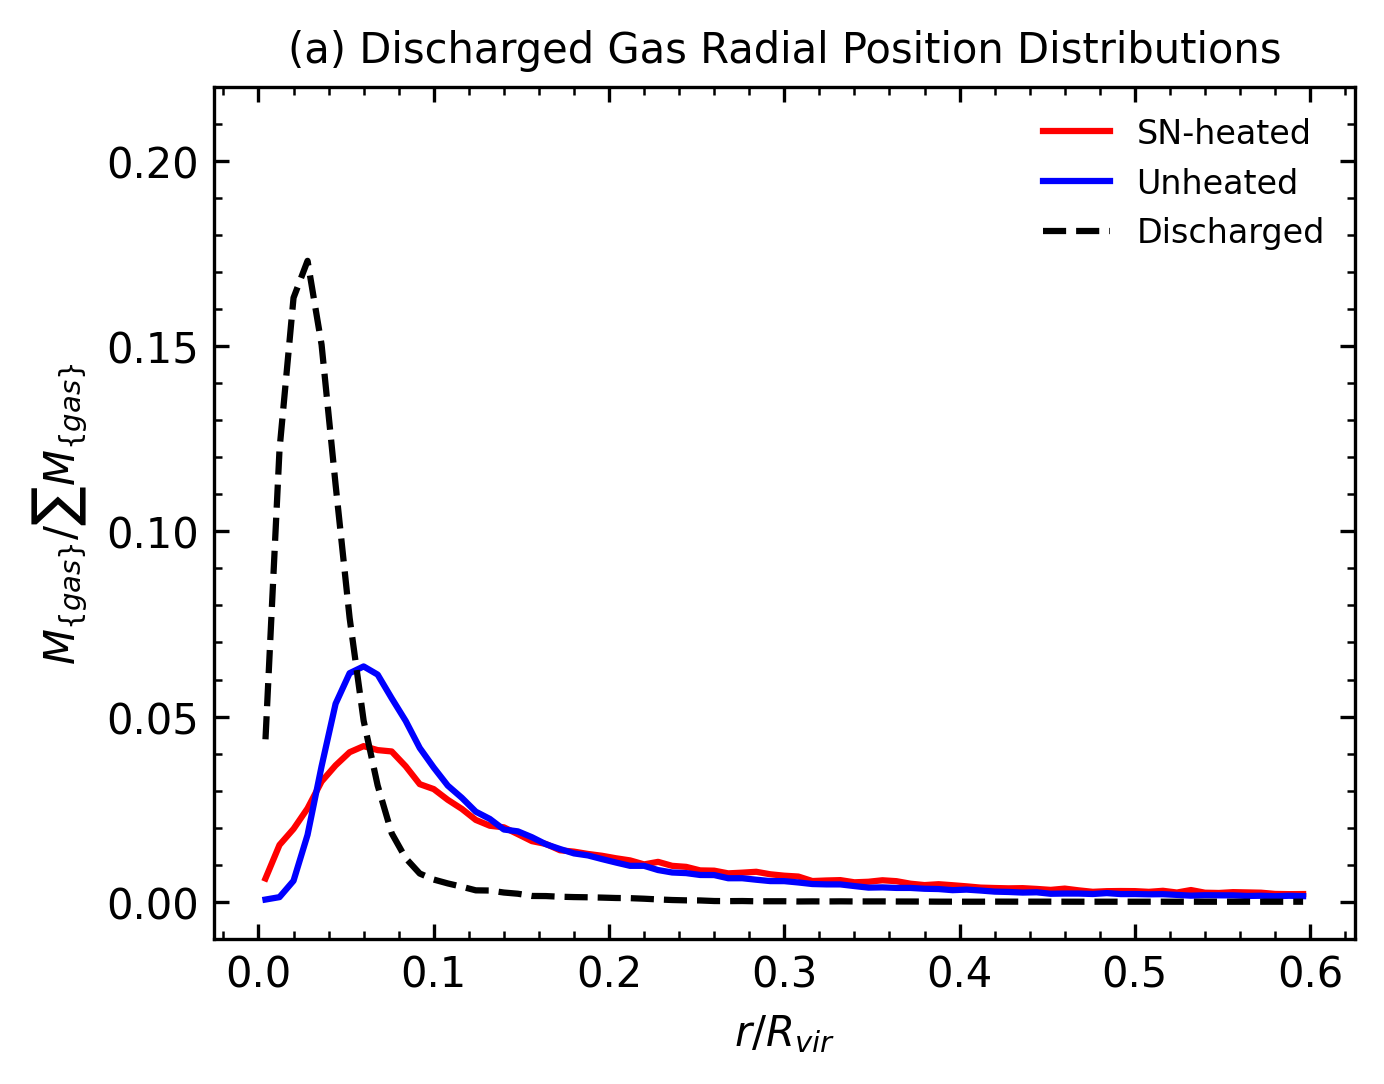

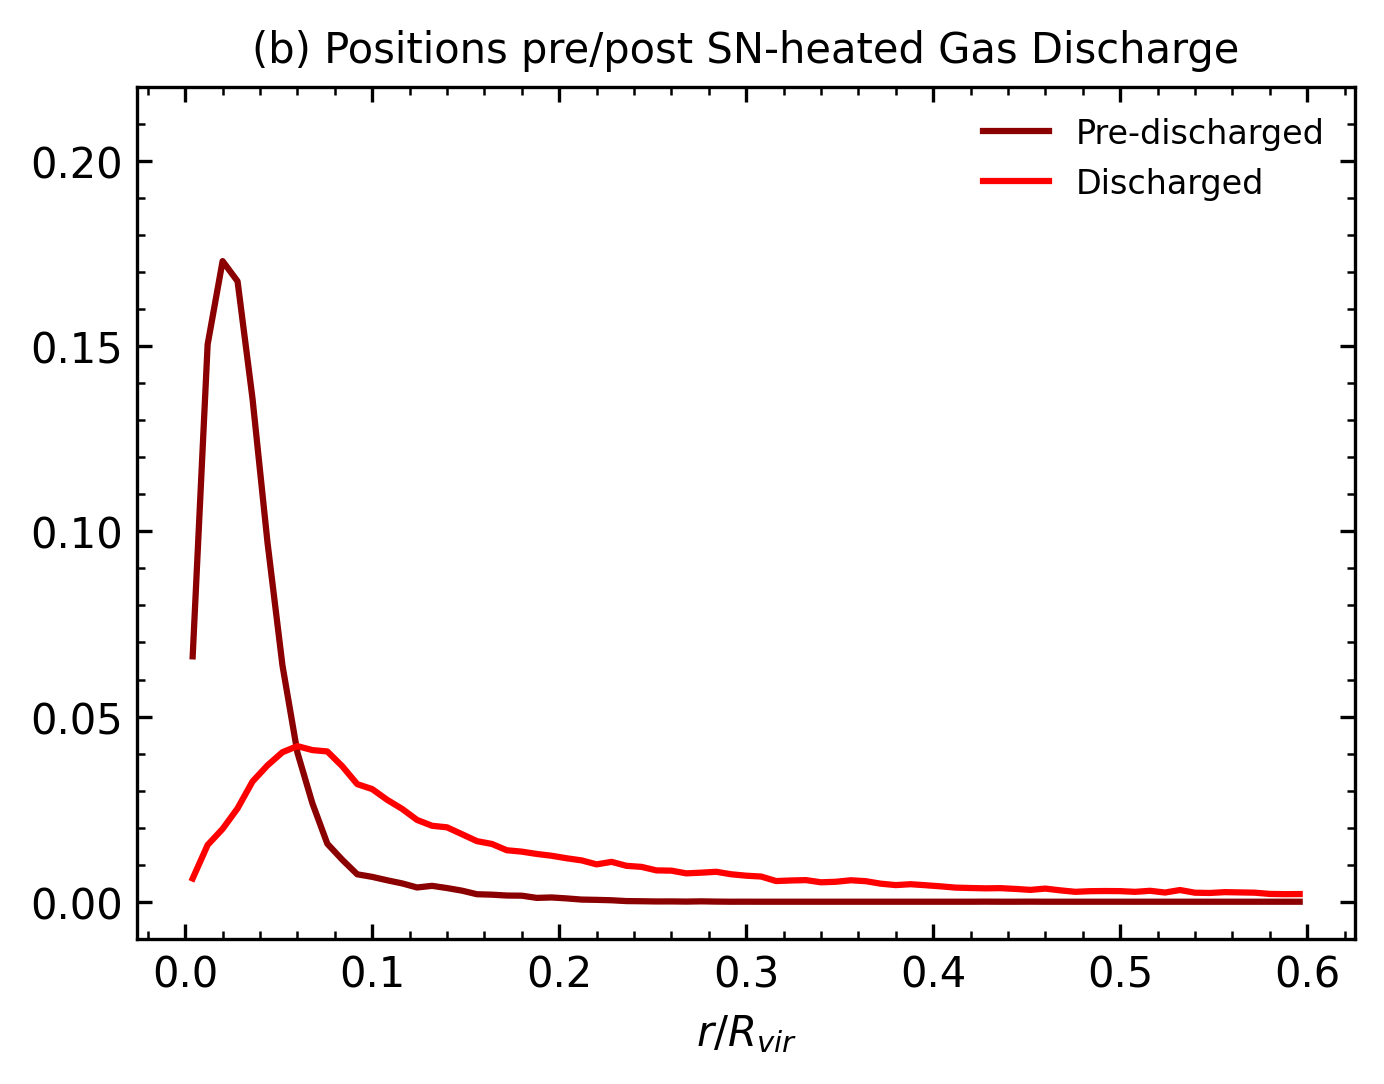

In [8]:
# compiling radial positions for each gas particle. data has precalculated key 
# 'r_per_Rvir', radial position normalized by the virial radius of the satellite, 
# that we will use for our position computations here.


##### plotting unheated vs. heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated', color='r')

y2, x = np.histogram(cold.r_per_Rvir, bins=bins, weights=wt(cold), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated', color='b')

y3, x = np.histogram(predischarged.r_per_Rvir, bins=bins, weights=wt(predischarged),
                     range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y3, label='Discharged', linestyle='--', color='black')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(a) Discharged Gas Radial Position Distributions', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.22)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))


ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/rPerRvir_1.pdf')



##### plotting discharged vs. pre-discharged, heated gas #####
# bins = 75
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True) # change to dpi=300 for printout.

y1, x = np.histogram(hot_predischarged.r_per_Rvir, bins=bins,
                     weights=wt(hot_predischarged), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='darkred')

y2, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Discharged', color='red')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(b) Positions pre/post SN-heated Gas Discharge', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
# plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.01,0.22)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/rPerRvir_2.pdf')

plt.show()

From the first plot, it is curious to find that SN-heated gas is discharged, on average, shorter distances away from satellites than unheated gas. It could, however, also be the case that the SN-heated gas is originating closer to satellite's centers than the unheated gas, but this is not something our current analysis can confirm. We should still note that a greater proportion of SN-heated gas is ejected to greater distances than is the case for unheated gas, as can seen by the red line overhead of the blue.

The second plot simply serves to confirm that the gas we are studying is indeed being discharged, with the dark red indicating pre-discharge positions, and light red indicating positions post-discharge.

___

### Radial Velocity Distributions <a class="anchor" id="velocity"></a>

#### Scaling by $V_{vir}$:
We first start scaling velocities according to $v_{eff} = v/v_{vir}$. Recall that the virial -- or circular -- velocity of a halo is defined by 
$$
    v_{vir} \equiv \sqrt{ \frac{G \cdot M_{vir}}{ r_{vir} } },
$$
with $G$ (in units of $kpc\cdot km^2 \cdot Msol^{-1} \cdot s^{-2}$) being the gravitational constant and $M_{vir}$ being the virial mass (the mass contained within $R_{vir}$) of said halo. $G$ is computed below, and the keys `sat_Mvir` for $M_{vir}$ and `satRvir` for $R_{vir}$ allow for quick computation of $v_{vir}$ for every gas particle's respective satellite.

___


In [9]:
# gravitational constant in units of kpc km**2 Msol**-1 s**-2 (matching sim. units).
G = c.G.to('kpc km2 / (M_sun s2)')

In [10]:
# compiling virial velocities for each particle's respective satellite.

# all pre-discharged gas.
pre_vvir = np.sqrt(G * predischarged.sat_Mvir / predischarged.satRvir) 

# all discharged gas.
post_vvir = np.sqrt(G * discharged.sat_Mvir / discharged.satRvir)

# reaccreted gas.
reac_vvir = np.sqrt(G * reaccreted.sat_Mvir / reaccreted.satRvir)

# SN-heated, pre-discharged gas.
preHot_vvir = np.sqrt(G * hot_predischarged.sat_Mvir / hot_predischarged.satRvir)

# SN-heated and unheated discharged gas.
hot_vvir = np.sqrt(G * hot.sat_Mvir / hot.satRvir)
cold_vvir = np.sqrt(G * cold.sat_Mvir / cold.satRvir)


# creating callable key for effective velocity.
predischarged['v_per_Vvir'] = predischarged.v / pre_vvir
discharged['v_per_Vvir'] = discharged.v / post_vvir
reaccreted['v_per_Vvir'] = reaccreted.v / reac_vvir

hot_predischarged['v_per_Vvir'] = hot_predischarged.v / preHot_vvir
hot['v_per_Vvir'] = hot.v / hot_vvir
cold['v_per_Vvir'] = cold.v / cold_vvir

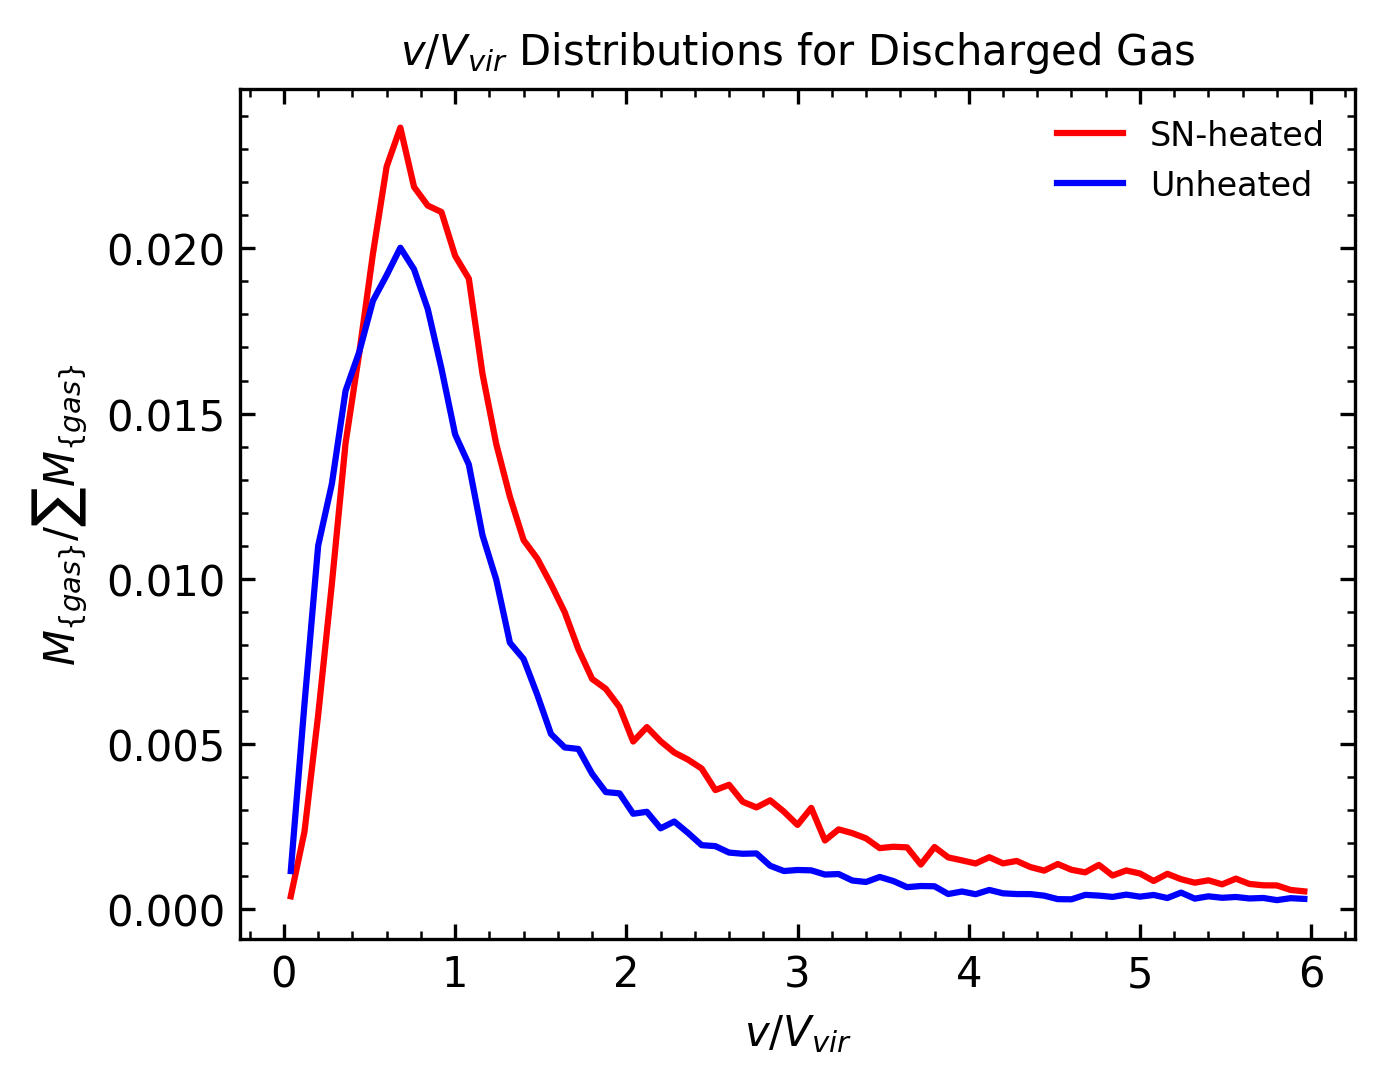

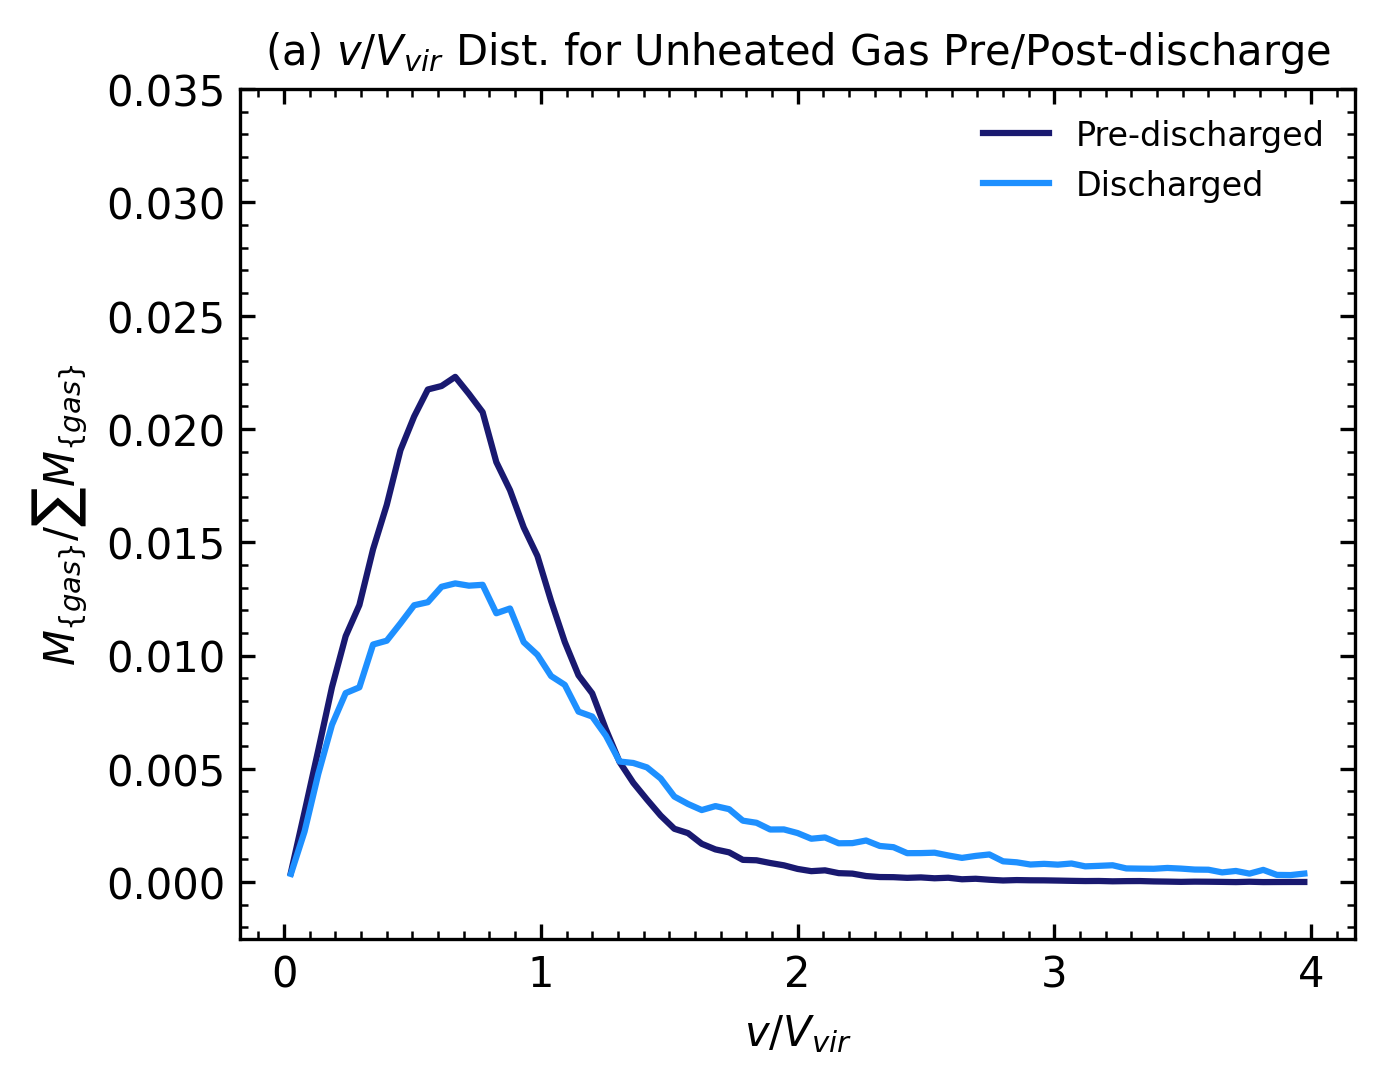

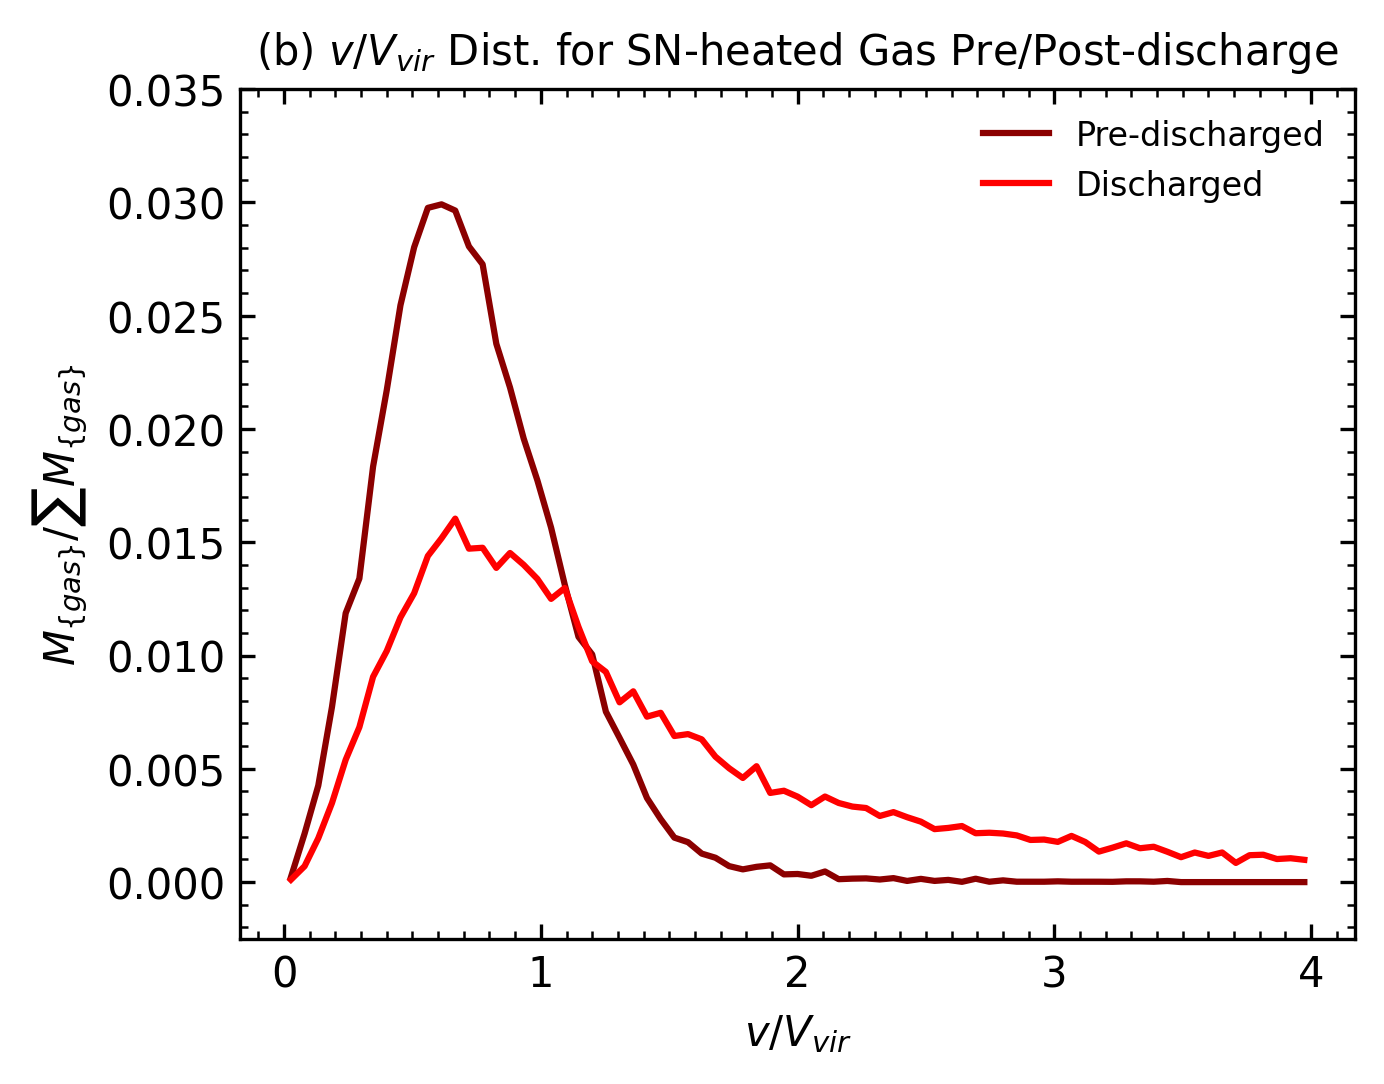

In [29]:
##### plotting all unheated vs. SN-heated, discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.v_per_Vvir, bins=bins, weights=wt(hot),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated', color='r')

y2, x = np.histogram(cold.v_per_Vvir, bins=bins, weights=wt(cold),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated', color='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('$v/V_{vir}$ Distributions for Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
# ax.set_ylim(-0.0025,0.08)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVvir_1.pdf')



##### plotting all discharged vs. gas pre-discharge #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(predischarged.v_per_Vvir, bins=bins, weights=wt(predischarged),
                     range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='midnightblue')

y1, x = np.histogram(cold.v_per_Vvir, bins=bins, weights=wt(cold), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', color='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(a) $v/V_{vir}$ Dist. for Unheated Gas Pre/Post-discharge',
             fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
ax.set_ylim(-0.0025,0.035)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVvir_2.pdf')



##### plotting SN-heated pre-discharged vs. SN-heated discharged gas #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot_predischarged.v_per_Vvir, bins=bins,
                     weights=wt(hot_predischarged), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='darkred')

y1, x = np.histogram(hot.v_per_Vvir, bins=bins, weights=wt(hot), range=(0, 4.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', color='red')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(b) $v/V_{vir}$ Dist. for SN-heated Gas Pre/Post-discharge',
             fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
ax.set_ylim(-0.0025,0.035)


ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVvir_3.pdf')
plt.show()

All gas is moving out from the center of the satellites nearly uniformly. This uniformity between datasets, particularly between pre- and post-discharge may result because the velocity measurements we are taking of some gas prior to discharge are in fact done when the gas is already on an exit trajectory. This is a flaw in our data collection procedure; just because gas is in its satellite's disk at one timestep and not at the next (for this was the way discharged particles were located), does not mean the stripping of the particle from the satellite only occured in that short timeframe 
(our 'pre-discharged' gas might be gas already experiencing discharge, or stripping, effects).

We should expect to see the same trend with escape velocity ratios below.

#### Scaling by $V_{esc}$:
We first start scaling velocities according to $v_{eff} = v/v_{esc}$, where we can calculate the escape velocity for each particle's satellite by the familiar relation
$$
v_{esc} = \sqrt{\frac{2GM_{vir}}{r_{sat}}},
$$
where $M_{vir}$ is the mass contained within $R_{vir}$ of the respective satellite (again, stored under the key `sat_Mvir`), and $r_{sat}$ is the radial position of the satellite from its host, which is to be computed below.

___


In [12]:
discharged.keys()

Index(['time', 'pid', 'rho', 'temp', 'mass', 'coolontime', 'r', 'r_per_Rvir',
       'x', 'y', 'z', 'satRvir', 'a', 'vx', 'vy', 'vz', 'v', 'r_rel_host',
       'r_rel_host_per_Rvir', 'x_rel_host', 'y_rel_host', 'z_rel_host',
       'hostRvir', 'vx_rel_host', 'vy_rel_host', 'vz_rel_host', 'v_rel_host',
       'sat_Xc', 'sat_Yc', 'sat_Zc', 'sat_vx', 'sat_vy', 'sat_vz', 'host_Xc',
       'host_Yc', 'host_Zc', 'host_vx', 'host_vy', 'host_vz', 'sat_Mstar',
       'sat_Mgas', 'host_Mstar', 'host_Mgas', 'sat_r_half', 'sat_r_gas',
       'host_r_half', 'host_r_gas', 'in_sat', 'in_host', 'in_other_sat',
       'in_IGM', 'dt', 'r_gal', 'host_r_gal', 'sat_disk', 'sat_halo',
       'host_disk', 'host_halo', 'other_sat', 'IGM', 'sat_Mvir', 'angle',
       'snHeated', 'key', 'v_per_Vvir'],
      dtype='object')

In [15]:
# function to compute the radial distance between a gas particle's satellite
# and the satellite's host.
@pynbody.derived_array
def rSat(gas):
    return np.sqrt((gas.sat_Xc-gas.host_Xc)**2
                   + (gas.sat_Yc-gas.host_Yc)**2 
                   + (gas.sat_Zc-gas.host_Zc)**2)

In [16]:
# compiling escaped velocities for each particle's respective satellite.

# all pre-discharged gas.
pre_vesc = np.sqrt(2 * G * predischarged.sat_Mvir / rSat(predischarged))

# all discharged gas.
post_vesc = np.sqrt(2 * G * discharged.sat_Mvir / rSat(discharged))

# reaccreted gas.
reac_vesc = np.sqrt(2 * G * reaccreted.sat_Mvir / rSat(reaccreted))

# SN-heated, pre-discharged gas.
preHot_vesc = np.sqrt(2 * G * hot_predischarged.sat_Mvir / rSat(hot_predischarged))

# SN-heated and unheated discharged gas.
hot_vesc = np.sqrt(2 * G * hot.sat_Mvir / rSat(hot))
cold_vesc = np.sqrt(2 * G * cold.sat_Mvir / rSat(cold))


# creating callable key for effective velocity.
predischarged['v_per_Vesc'] = predischarged.v / pre_vesc
discharged['v_per_Vesc'] = discharged.v / post_vesc
reaccreted['v_per_Vesc'] = reaccreted.v / reac_vesc

hot_predischarged['v_per_Vesc'] = hot_predischarged.v / preHot_vesc
hot['v_per_Vesc'] = hot.v / hot_vesc
cold['v_per_Vesc'] = cold.v / cold_vesc

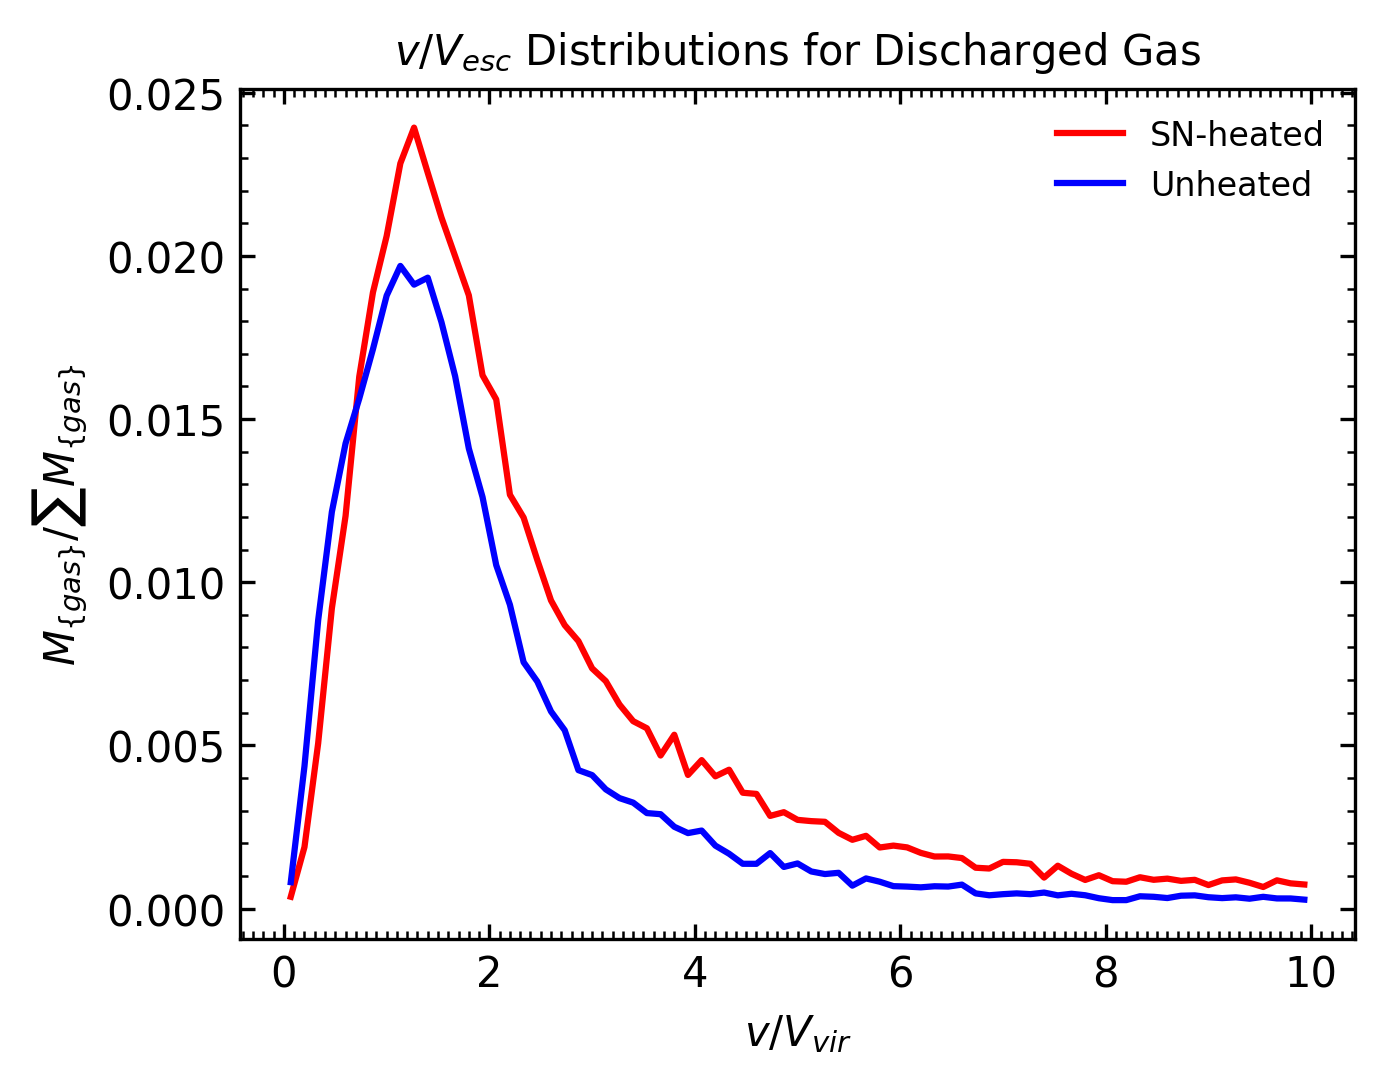

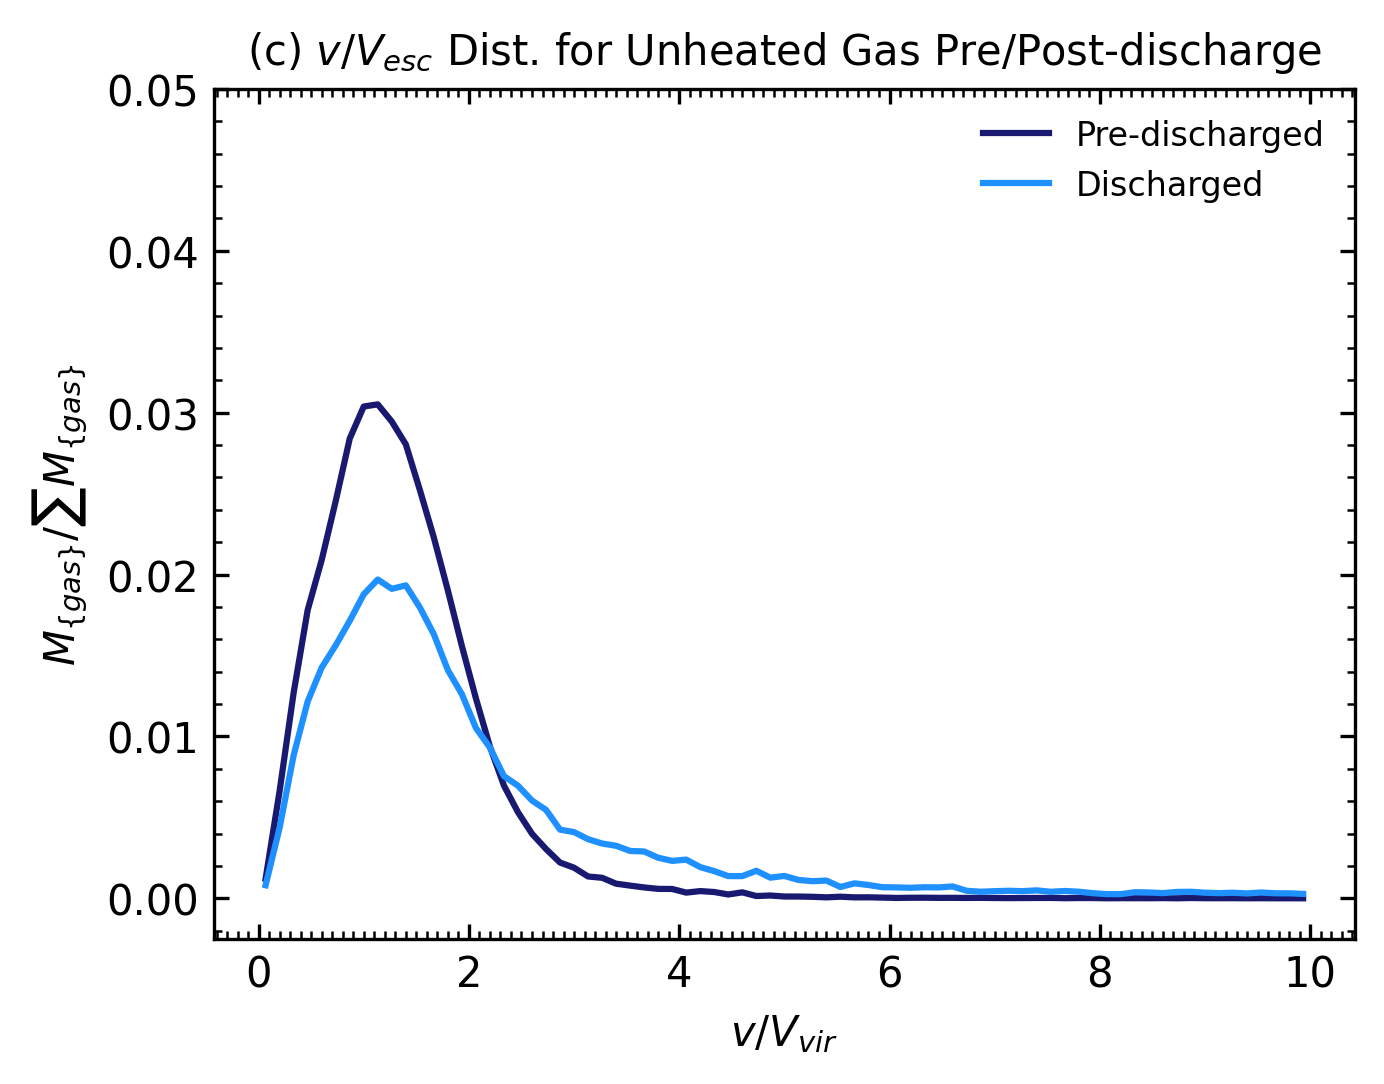

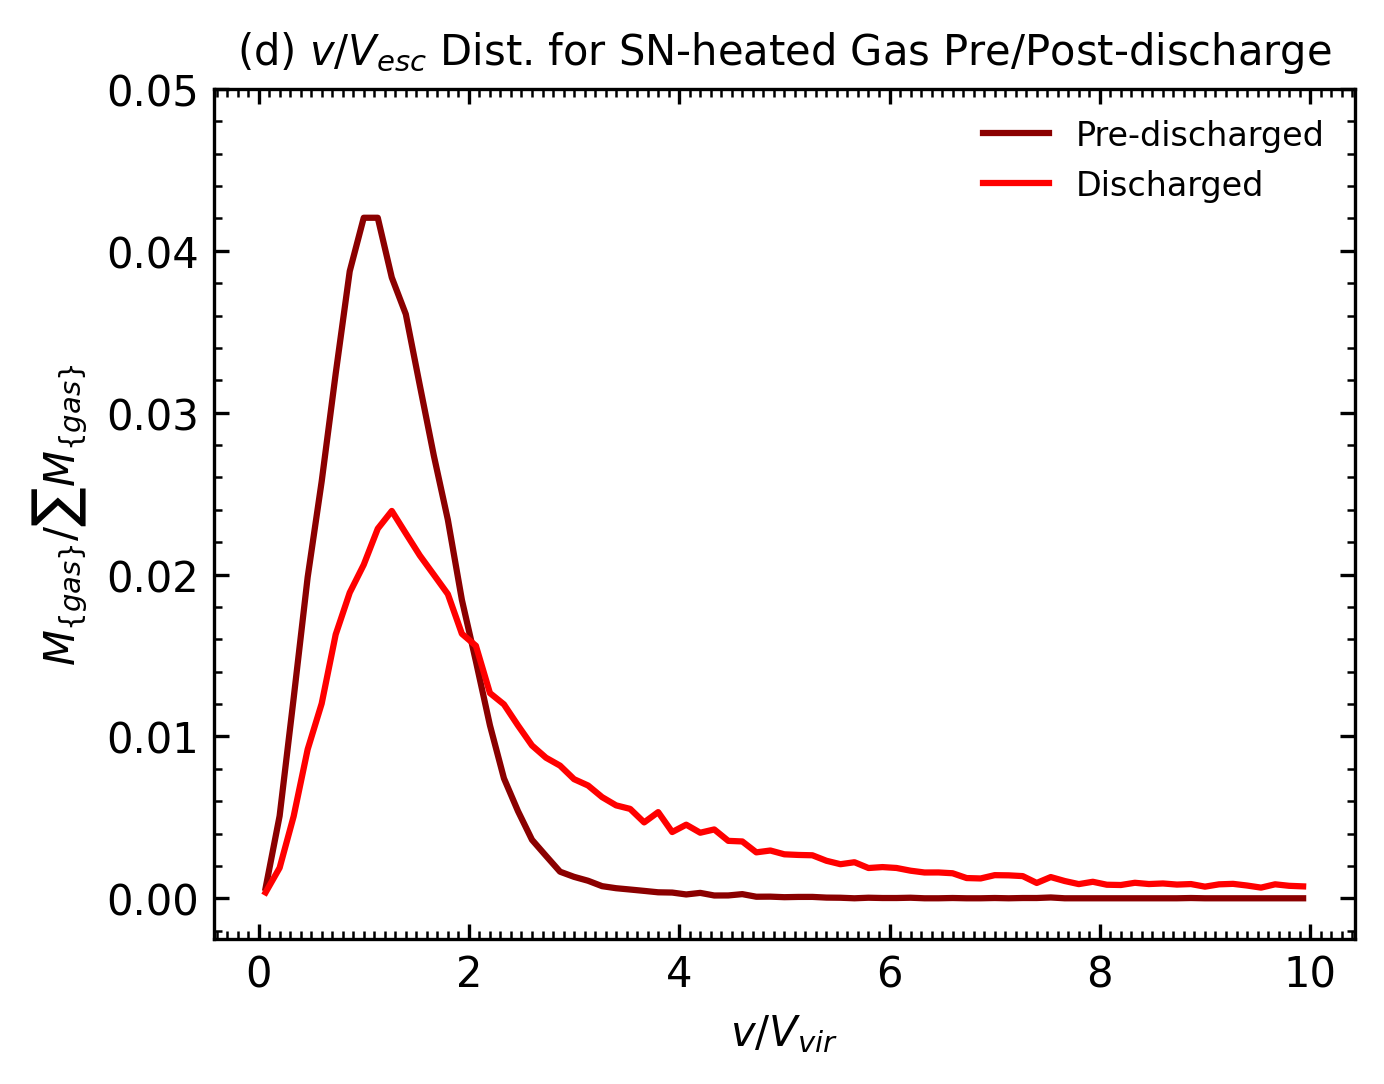

In [30]:
##### plotting all unheated vs. SN-heated, discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot.v_per_Vesc, bins=bins, weights=wt(hot), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated', color='r')

y2, x = np.histogram(cold.v_per_Vesc, bins=bins, weights=wt(cold), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated', color='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('$v/V_{esc}$ Distributions for Discharged Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
# ax.set_ylim(-0.0025,0.08)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVesc_1.pdf')



##### plotting all discharged vs. gas pre-discharge #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(predischarged.v_per_Vesc, bins=bins, weights=wt(predischarged),
                     range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='midnightblue')

y1, x = np.histogram(cold.v_per_Vesc, bins=bins, weights=wt(cold), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', color='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(c) $v/V_{esc}$ Dist. for Unheated Gas Pre/Post-discharge',
             fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
ax.set_ylim(-0.0025,0.05)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.002))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVesc_2.pdf')



##### plotting SN-heated pre-discharged vs. SN-heated discharged gas #####
# bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(hot_predischarged.v_per_Vesc, bins=bins,
                     weights=wt(hot_predischarged), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', color='darkred')

y1, x = np.histogram(hot.v_per_Vesc, bins=bins, weights=wt(hot), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', color='red')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(d) $v/V_{esc}$ Dist. for SN-heated Gas Pre/Post-discharge',
             fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
ax.set_ylim(-0.0025,0.05)


ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.002))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVesc_3.pdf')
plt.show()

Based on observations for the distribution of $v/V_{vir}$, the first plot is as we expect. Just as well, the second and third plots reveal a similar distinction between the pre- and post-discharged gas.

___

### Satellite Mass Histories <a class="anchor" id="masshistories"></a>

- Computing the mass of gas ever in satellite disks...
- Ever discharged...
- Ever SN-heated...
- And ever both discharged and SN-heated.

To Note: the masses of gas particles vary over time in the sims, so we make the decision to include the largest mass ever attributed to a particle when tracking it in these computations (see the `discharged` set for examples).

In [30]:
# importing all data.
predischarged, hot_predischarged, discharged = read_all_discharged()
all_accreted, reaccreted = read_accreted()

# gas SN-heated/unheated prior to discharge.
hot = discharged[discharged['snHeated']==True]  # heated.
cold = discharged[discharged['snHeated']==False]  # unheated.

sngas = read_sngas()  # all SN-heated

> Returning (predischarged, discharged, hot_predischarged) for all satellites <
> Returning (accreted, reaccreted) for all satellites <
> Returning (SN-heated gas) for all satellites <


In [15]:
# creating df containing all gas particles from satellites in 'keys'. This cell does not need to be run
# if df already exists.

keys = ['h148_12','h148_27','h148_34','h148_38','h148_55','h148_65','h148_249',
        'h148_251','h148_282','h229_14','h229_18','h229_20','h229_22',
        'h229_49','h242_21','h242_38','h242_69','h329_29','h329_117']


for key in tqdm.tqdm(keys):
    sim = str(key[:4])
    haloid = int(key[5:])
    data = read_tracked_particles(sim, haloid, verbose=False)

    filepath = f'{rootPath}Stellar_Feedback_Code/SNeData/all_particles.hdf5'
#     print(f'Saving {key} all particles to {filepath}')
    data.to_hdf(filepath, key=key)

100%|███████████████████████████████████████████| 19/19 [00:17<00:00,  1.10it/s]


In [31]:
# pulling data on all tracked gas in selected satellites into df.

allGas = pd.DataFrame()   
keys = get_keys()

for i,key in enumerate(keys):
    i += 1
    sim = key[:4]
    haloid = int(key[5:])
    allGas1 = pd.read_hdf(f'{rootPath}Stellar_Feedback_Code/SNeData/all_particles.hdf5',
                          key=key)
    allGas1['key'] = key
    allGas = pd.concat([allGas, allGas1])

In [33]:
initial = allGas[allGas.time == allGas.time.min()]
initial = initial[initial.sat_disk == True]

# mass ever in disk
diskGas = pd.concat([all_accreted, initial])

In [34]:
# creating a 'host' key specifying host galaxy for each particle's satellite (this makes it straightforward
# to also determine mass histories for each individual host galaxy).

diskGas['host'] = [x[0:4] for x in np.array(diskGas['key'])]  # list comprehension.
discharged['host'] = [x[0:4] for x in np.array(discharged['key'])]
sngas['host'] = [x[0:4] for x in np.array(sngas['key'])]
hot['host'] = [x[0:4] for x in np.array(hot['key'])]

In [46]:
# selecting for specific host (optional). Making copies so we do not overwrite original data.

host = 'h329'

if host:
    diskGas_c = diskGas[diskGas['host'] == host]
    discharged_c = discharged[discharged['host'] == host]
    sngas_c = sngas[sngas['host'] == host]
    hot_c = hot[hot['host'] == host]

else:
    diskGas_c = diskGas
    discharged_c = discharged
    sngas_c = sngas
    hot_c = hot
    
np.unique(discharged_c.host)  # check that correct satellite is selected.

array(['h329'], dtype=object)

In [47]:
mass1 = []
mass2 = []
mass3 = []
mass4 = []

# summing all unique mass.
for i in tqdm.tqdm(np.unique(diskGas_c['pid'])):
    mass = np.unique(diskGas_c[diskGas_c['pid'] == i]['mass'])
    mass1 = np.append(mass1, mass)

for i in tqdm.tqdm(np.unique(discharged_c['pid'])):
    mass = np.unique(discharged_c[discharged_c['pid'] == i]['mass'])
    mass = np.amax(mass)  # particle mass changes over time; selecting its largest.
    mass2 = np.append(mass2, mass)
    
for i in tqdm.tqdm(np.unique(sngas_c['pid'])):
    mass = np.unique(sngas_c[sngas_c['pid'] == i]['mass'])
    mass = np.amax(mass)
    mass3 = np.append(mass3, mass)

for i in tqdm.tqdm(np.unique(hot_c['pid'])):
    mass = np.unique(hot_c[hot_c['pid'] == i]['mass'])
    mass = np.amax(mass)
    mass4 = np.append(mass4, mass)

print('Total mass ever in satellite disks: {0:1.2e}'.format(mass1.sum()), 'Msol \n')
print('Total mass ever discharged: {0:1.2e}'.format(mass2.sum()), 'Msol \n')
print('Total mass ever SN-heated: {0:1.2e}'.format(mass3.sum()), 'Msol \n')
print('Total mass ever discharged with SN-heating: {0:1.2e}'.format(mass4.sum()),
      'Msol')

100%|███████████████████████████████████████| 402/402 [00:00<00:00, 4949.93it/s]

Total mass ever in satellite disks: 4.89e+07 Msol 

Total mass ever discharged: 7.14e+07 Msol 

Total mass ever SN-heated: 3.70e+07 Msol 

Total mass ever discharged with SN-heating: 1.05e+07 Msol


In [53]:
# finding min and max times at which particles here were tracked in simulations.
print('Earliest time: {0:1.2f} Gyrs'.format(allGas.time.min()),
      '\n Latest time: {0:1.2f} Gyrs'.format(allGas.time.max()))

Earliest time: 3.46 Gyrs 
 Latest time: 13.80 Gyrs


##  Insights From Gas Temperatures <a class="anchor" id="temperatures"></a>

We take a straightforward visualization of the distribution of temperatures (on a logarithmic scale) of SN-heated and unheated gas to determine if significant difference exists between the two gas sets.

___


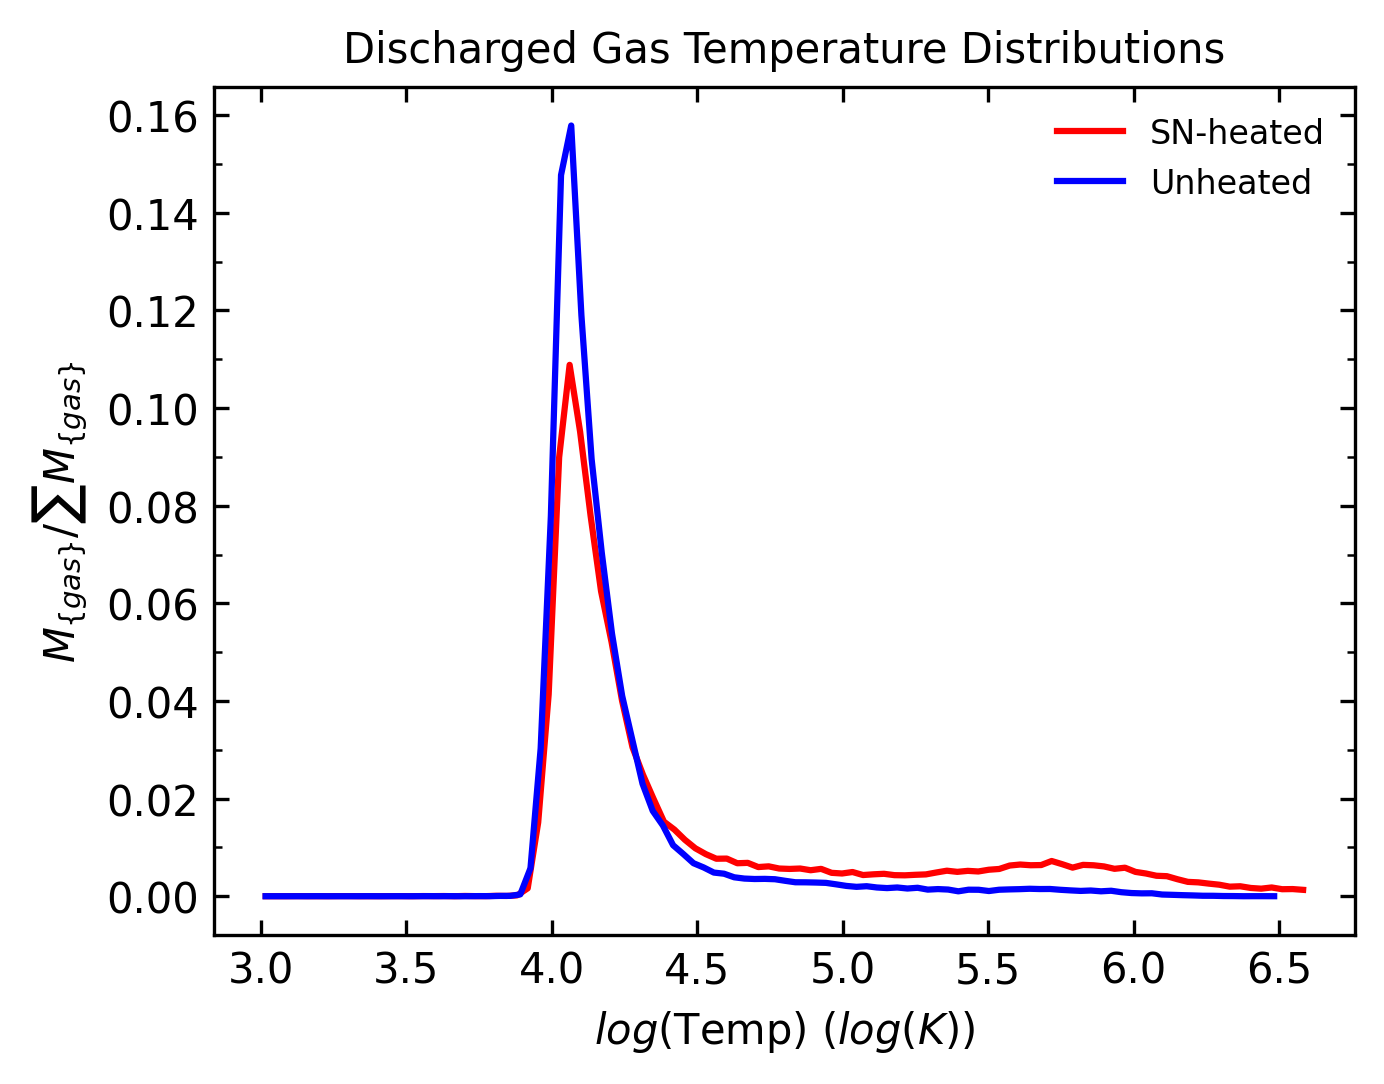

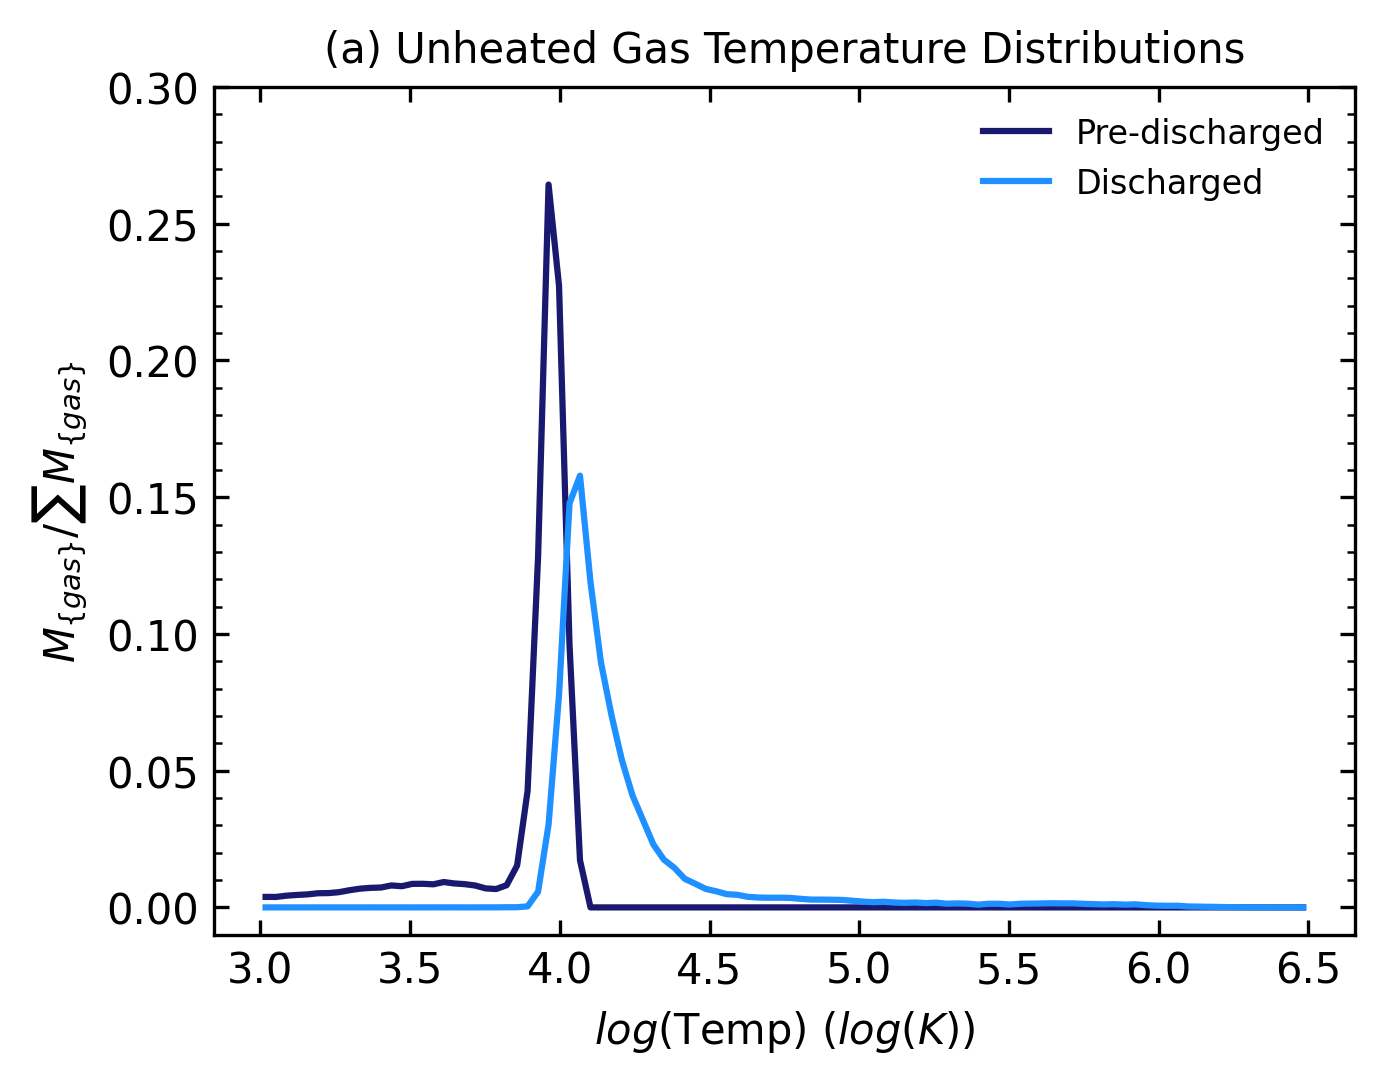

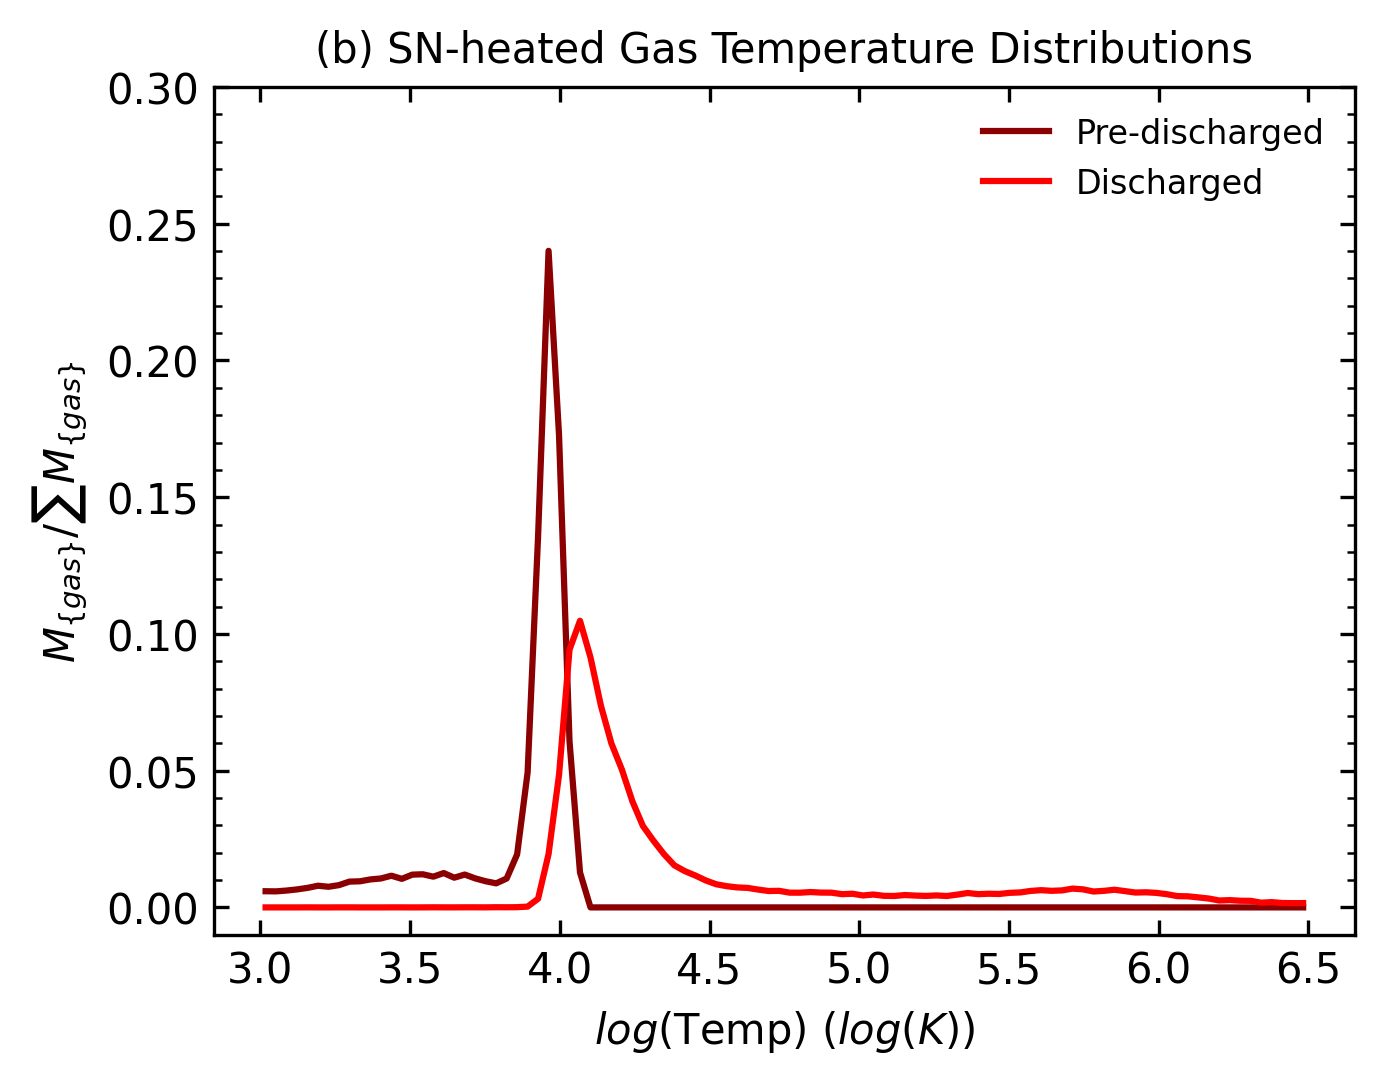

In [31]:
##### plotting discharged vs. heated gas #####
bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(hot.temp), bins=bins, weights=wt(hot), range=(3.0,6.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated', c='r')

y2, x = np.histogram(np.log10(cold.temp), bins=bins, weights=wt(cold), range=(3.0,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated', c='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Discharged Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'$log$(Temp) ($log(K)$)')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(3,8)
# ax.set_ylim(-0.01,0.30)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/T_dist1.pdf')



##### plotting unheated discharged vs. pre-discharged gas #####
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(predischarged.temp), bins=bins, weights=wt(predischarged),
                     range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', c='midnightblue')

y1, x = np.histogram(np.log10(cold.temp), bins=bins, weights=wt(cold), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', c='dodgerblue')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(a) Unheated Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'$log$(Temp) ($log(K)$)')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(2,7)
ax.set_ylim(-0.01,0.3)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/T_dist2.pdf')



##### plotting pre-discharge heated vs. heated gas #####
# bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y1, x = np.histogram(np.log10(hot_predischarged.temp), bins=bins,
                     weights=wt(hot_predischarged), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Pre-discharged', c='darkred')

y1, x = np.histogram(np.log10(hot.temp), bins=bins, weights=wt(hot), range=(3,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='Discharged', c='r')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('(b) SN-heated Gas Temperature Distributions', fontsize='medium')
ax.set_xlabel(r'$log$(Temp) ($log(K)$)')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(2,8)
ax.set_ylim(-0.01,0.3)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/T_dist3.pdf')
plt.show()

Based on observations for the distribution of $v/V_{vir}$, the first plot is as we expect. Just as well, the second and third plots reveal a similar distinction between the pre- and post-discharged gas.

___


##  Exit Angles of Discharged Gas <a class="anchor" id="angles"></a>

In line with the treatment given by Hollis Akins in his ram pressure stripping (RPS) analysis, we distinguish SN-heated from unheated gas to identify any noteworthy differences between these groups with regards to the angles at which gas is ejected from satellites.

___


In [33]:
# constructing bins for exit angle histograms.
N = 30
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

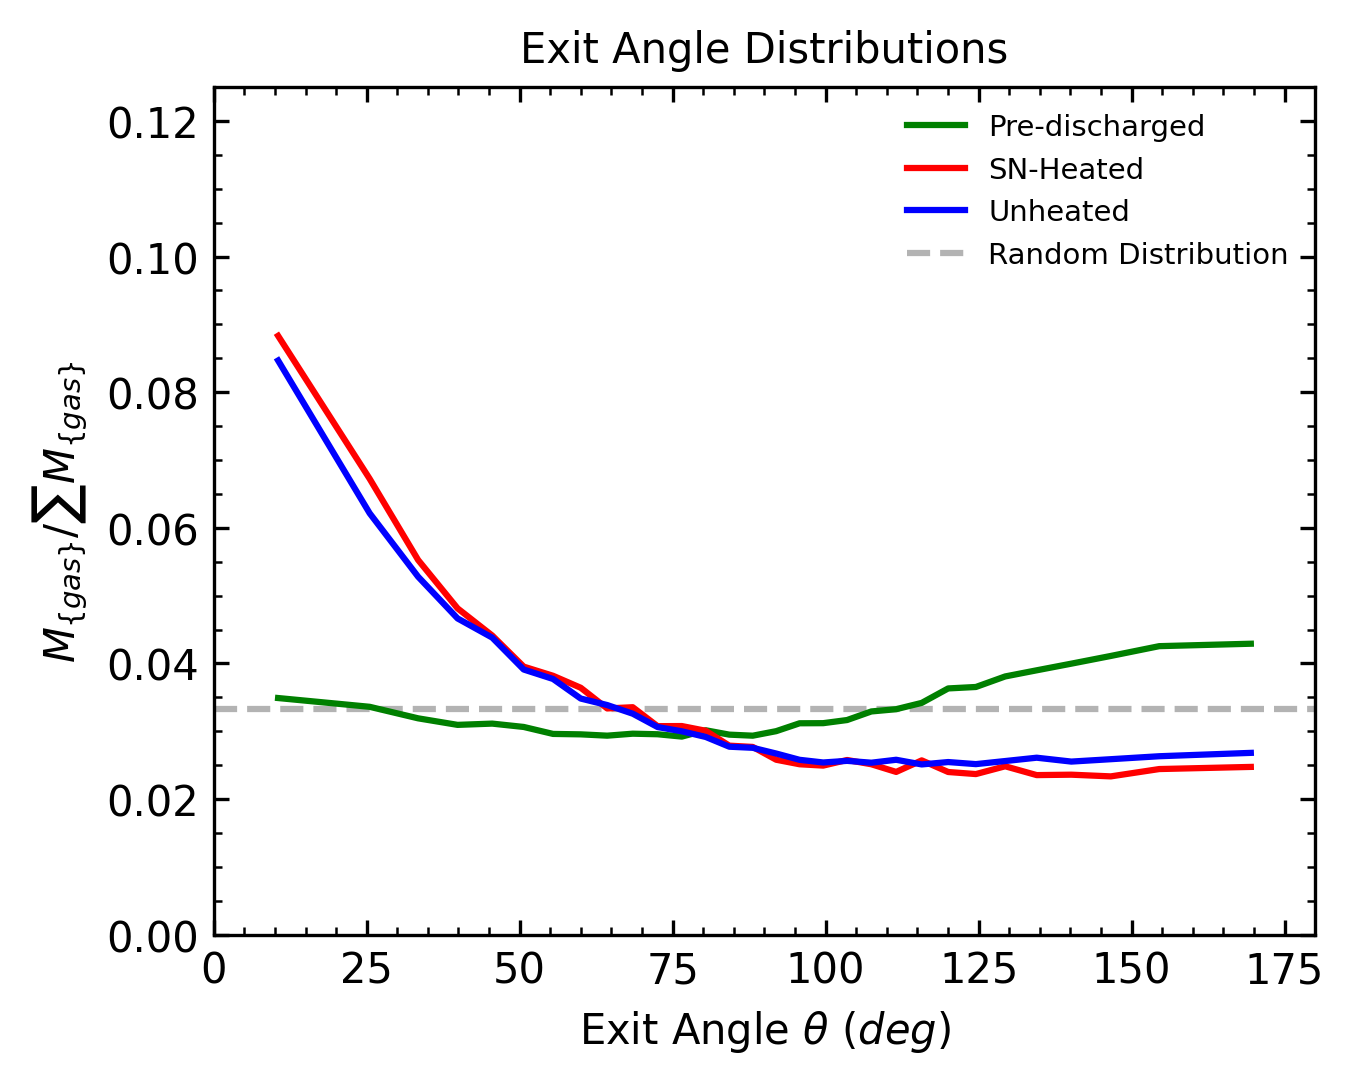

In [34]:
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True) 

# applying conditional on distances of gas from center of satellite; collecting 
# frequency and bin information for plot.
y1, bins = np.histogram(predischarged.angle, bins=bins, weights=wt(predischarged))
ax.plot(bincenters, y1, label='Pre-discharged', c='green')

y2, bins = np.histogram(hot.angle, bins=bins, weights=wt(hot))
ax.plot(bincenters, y2, label='SN-Heated', c='r')

y3, bins = np.histogram(cold.angle, bins=bins, weights=wt(cold))
ax.plot(bincenters, y3, label='Unheated', c='b')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
ax.set_title('Exit Angle Distributions', fontsize='medium')
ax.set_xlabel(r'Exit Angle $\theta$ ($deg$)')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/angles_dist.pdf')
plt.show()

From the above, most glaring is that SN-heated and unheated discharged gas both exit satellites at near identical distribution of angles. For the whole of discharged gas, however, we observe the expected preference for small angles, evidently a consequence of RPS.

It may prove useful later on to distinguish these discharge angles by satellite's point at infall (PAI) and radial distances of discharged gas.

___

## Proportions of Discharged Gas SN-heated Across Range of  Radial Distances <a class="anchor" id="fraction"></a>

In this section, we seek to track the proportion of satellite gas SN-heated that has been discharged to each effective radius $r_{eff}$. 

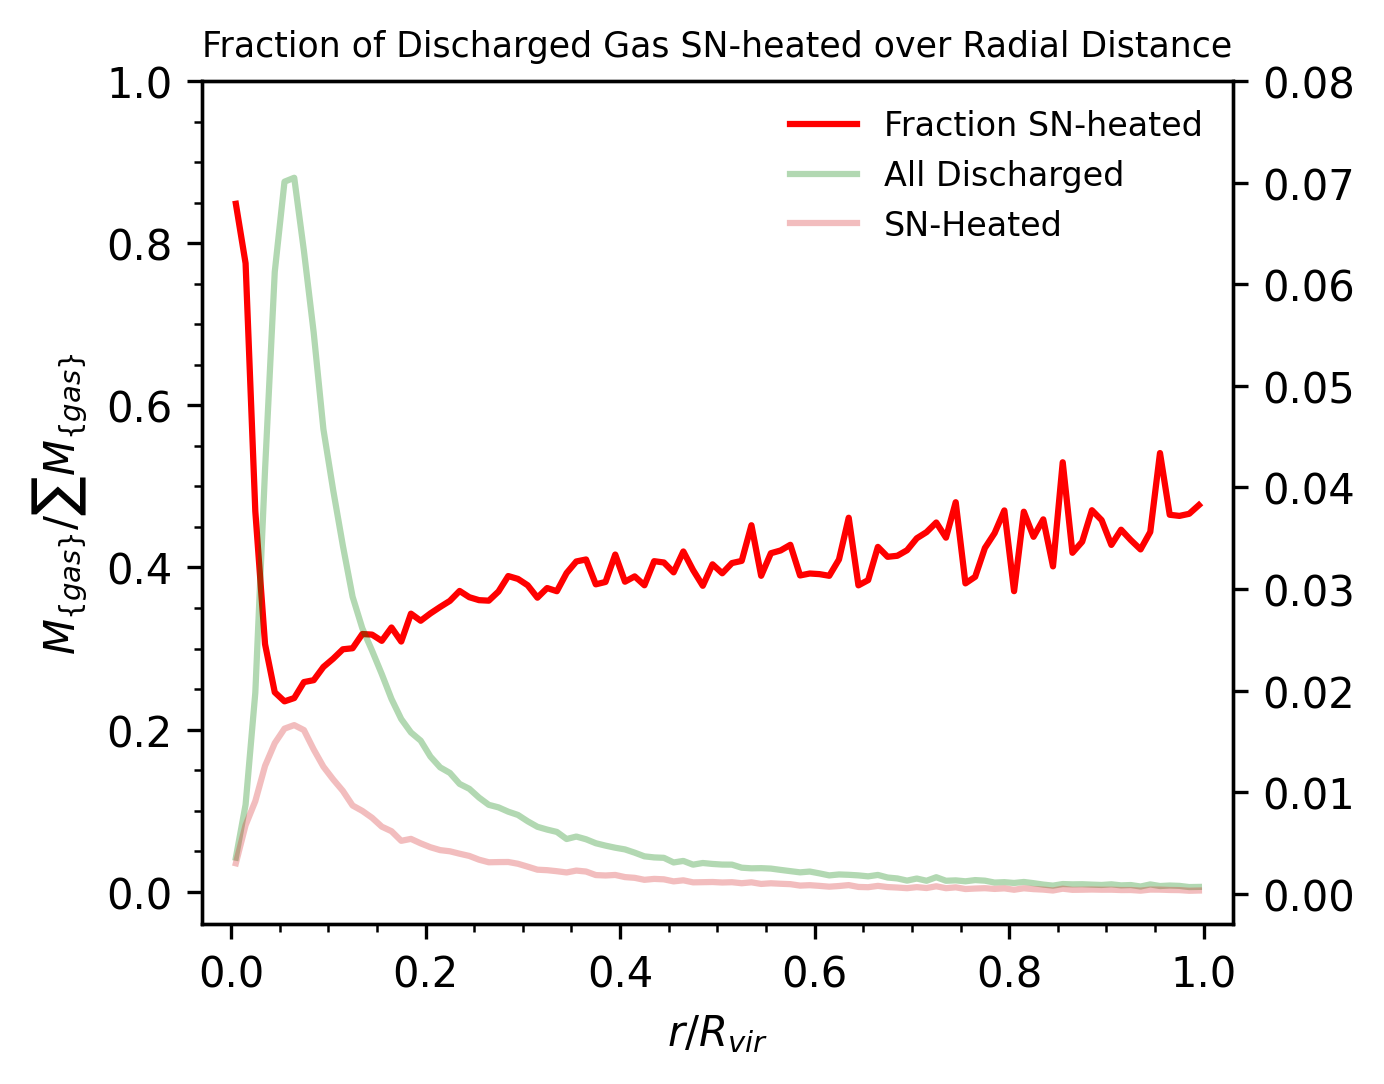

In [52]:
bins = 100
rangemax = 1.0

# assigning particles in each set to equal sets of bins.

# all discharged gas.
post, x = np.histogram(discharged.r_per_Rvir, bins=bins, range=(0,rangemax))

# SN-heated, discharged.
postHot, x = np.histogram(hot.r_per_Rvir, bins=bins, range=(0,rangemax))


# computing fraction hot/all for each bin.
sn_ratio = np.array([])

for i in range(0, bins):
    ratio = postHot[i]/post[i]
    sn_ratio = np.append(sn_ratio, ratio)
    i += 1


### plotting fractions heated/discharged for different r/Rvir bins ###
# ax1 = plot of heated/discharged ratios;
# ax2 = plot for percent mass of discharged and SN-heated, discharged gas, respectively, 
# at different r/Rvir.
fig, ax1 = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)
ax2 = ax1.twinx()

# fraction sne/all:
bincenters = 0.5*(x[1:] + x[:-1])
ax1.plot(bincenters, sn_ratio, label='Fraction SN-heated', c='r', zorder=-1000)

# mass distributions:
y1, x = np.histogram(discharged.r_per_Rvir, bins=bins, weights=wt(discharged),
                     range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='All Discharged', c='g', alpha=0.3, zorder=-1)

y1, x = np.histogram(hot.r_per_Rvir, bins=bins, weights=wt(hot,discharged),
                     range=(0,rangemax))
bincenters = 0.5*(x[1:] + x[:-1])
ax2.plot(bincenters, y1, label='SN-Heated', c='tab:red', alpha=0.3, zorder = -1)


ax1.set_title('Fraction of Discharged Gas SN-heated over Radial Distance',
              fontsize='small')
ax1.set_xlabel(r'$r/R_{vir}$')
ax1.set_ylabel('% SN-heated')
ax1.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
fig.legend(frameon=False, fontsize='8', bbox_to_anchor=(0.9, 0.94))
# ax2.legend(frameon=False, fontsize='8')

ax1.set_xlim(-0.03,1.03)
ax1.set_ylim(-0.04,1)
ax2.set_ylim(-0.003,0.08)

ax1.tick_params(axis ='y') 
ax2.tick_params(axis ='y')
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))

plt.savefig('F21plots/sn_fraction.pdf')

plt.show()

## General Distribution of Reaccretion Times <a class="anchor" id="reaccretion"></a>

For this treatment, we define a new parameter
$$
    reaccretion\ time = time\ at\ reaccretion - time\ at\ discharge
$$
to facilitate our study. (In practice, 'time at reaccretion' is the timestep just following a reaccretion event for a gas particle, and 'time at discharged' is the timestep just following a corresponding discharge event for said particle.) These reaccretion times can be called via the `recycleTime` key of the *reaccreted* dataset.


Finally, define 
$$
M_{reac}
$$
to be the mass of a single selection of reaccreted gas. We will use this in normalizing our data by total gas mass, and determine what fractions of reaccreted particles (in percent of total mass) adhere to particular critera.

____


In [54]:
# splitting reaccreted set into subsets based on whether reaccreted gas particles 
# experienced SNe-heating prior to discharge or not. 
hot_reac = reaccreted[reaccreted.snHeated==True]
cold_reac = reaccreted[reaccreted.snHeated==False]

# creating weight attributes for plotting.
cold_reac['weight'] = cold_reac['mass'] / discharged[discharged.snHeated==False]['mass'].sum()
hot_reac['weight'] = hot_reac['mass'] / discharged[discharged.snHeated==True]['mass'].sum()

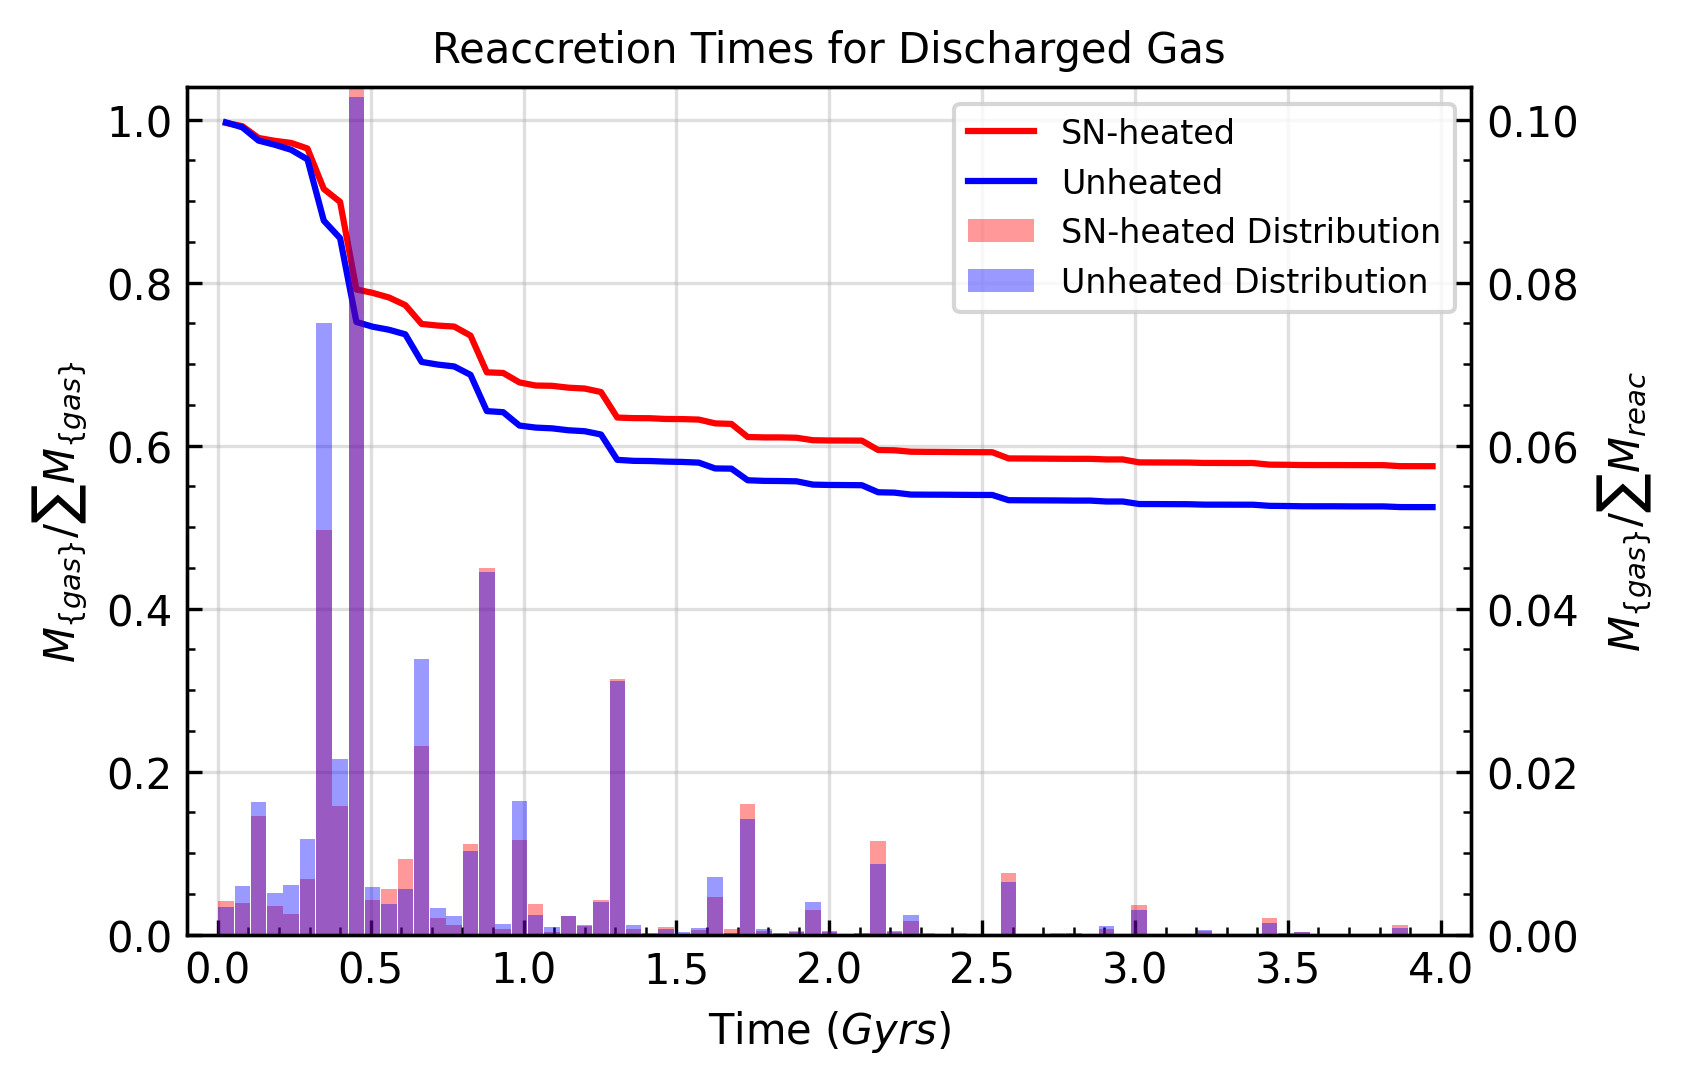

In [56]:
### basic histogram of reaccretion times w/ accumulation plot ###
# ax1 = accumulation plots;
# ax2 = histograms marking the percentage of reaccreted particles falling within 
#       specified reaccretion time bins.

bins = 75
rangemax = 4.0
fig, ax1 = plt.subplots(1, 1, dpi=300, figsize=(5.5,3.5), constrained_layout=True)
ax2 = ax1.twinx()

# accumulation plot:
# accumulation plot for SN-heated.
y1, x = np.histogram(hot_reac.recycleTime, bins=bins, weights=wt(hot_reac, hot),
                     range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
sum = 1 - np.cumsum(y1)
ax1.plot(bincenters, sum, alpha=1.0, c='red', label='SN-heated')

# accumulation plot for unheated.
y1, x = np.histogram(cold_reac.recycleTime, bins=bins, weights=wt(cold_reac, cold),
                     range=(0, 4))
bincenters = 0.5*(x[1:] + x[:-1])
sum = 1 - np.cumsum(y1)
ax1.plot(bincenters, sum, alpha=1.0, c='blue', label='Unheated')

# histograms:
ax2.hist(hot_reac.recycleTime, bins=bins, weights=wt(hot_reac, hot), color='red',
         alpha=0.4, rwidth=0.95, range=(0, 4), label='SN-heated Distribution')
ax2.hist(cold_reac.recycleTime, bins=bins, weights=wt(cold_reac, cold), color='blue',
         alpha=0.4, rwidth=0.95, range=(0, 4), label='Unheated Distribution')


ax1.set_title('Reaccretion Times for Discharged Gas', fontsize='medium')
ax1.set_xlabel(r'Time ($Gyrs$)')
ax1.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax2.set_ylabel('$M_{\{gas\}} / \sum M_{reac}$')


# # ask matplotlib for the plotted objects and their labels to make joined legend.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc=0, fontsize='8')

ax1.set_xlim(-0.1,4.1)
ax1.set_ylim(0,1.04)
ax2.set_ylim(0,0.104)

ax1.tick_params(direction='in',which='both')
ax2.tick_params(direction='in',which='both')
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
 
ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax1.grid(alpha=0.4, zorder=-1000)

plt.savefig('F21plots/reaccretion.pdf')

plt.show()

##  Repeating Analyses for Permanently Expelled  Gas <a class="anchor" id="expelled"></a>

We repeat the analyses given above, but for the case of gas particles permanently expelled. We define gas particles as 'expelled' if they are not reaccreted onto the disk of their host satellite within 4 Gyrs. This subset is computed below by a standard masking procedure.

See Previous sections for explanations of the calculations used below.
____
____


In [25]:
y = np.array(discharged['pid'])  # particle ids of discharged gas...
x = np.array(reaccreted['pid'])  # ...and for reaccreted.

# applying mask:
index = np.argsort(x)
sorted_x = x[index]  # Sorted list of ids pre discharged                        
sorted_index = np.searchsorted(sorted_x, y)
yindex = np.take(index, sorted_index, mode="clip")
mask = x[yindex] != y
result = np.ma.array(yindex, mask=mask)
expelled = discharged.iloc[result[result.mask].data]  # permanently discharged gas.

hot_exp = expelled[expelled['snHeated']==True]  # SN-heated, expelled gas.
cold_exp = expelled[expelled['snHeated']==False]  # unheated, expelled.

In [26]:
x,y,expelled['pid']
np.sum(result.mask)

55857

In [27]:
hot_exp

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated,key
408352,8.198053,11594066,2.692264,1.635553e+04,27670.619205,8.203620,0.991334,0.029448,0.837719,0.529658,...,False,True,False,False,False,False,7.288340e+09,130.319338,True,h148_27
26731,8.198053,16979111,0.001075,1.724781e+05,28047.532164,8.164057,5.839659,0.135863,-4.903893,-0.203607,...,False,True,False,False,False,False,NaN,3.698741,True,h148_12
36754,8.608831,16980035,0.001433,1.017214e+06,27926.396250,8.510861,7.668005,0.195993,-3.820413,4.252954,...,False,False,False,False,False,True,NaN,21.326136,True,h148_12
36763,8.608831,16980090,0.087440,9.590262e+03,29640.854046,8.543621,0.914088,0.023364,-0.537113,0.349077,...,False,True,False,False,False,False,NaN,36.810183,True,h148_12
13607,7.336092,13721775,0.001962,1.789903e+04,26681.168717,7.078478,4.318399,0.180582,1.420800,-2.328748,...,False,True,False,False,False,False,NaN,152.489228,True,h148_249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44945,9.921974,3044146,0.004278,1.419759e+04,26563.821861,9.619454,6.354436,0.219469,0.557002,-2.724372,...,False,True,False,False,False,False,NaN,74.241945,True,h148_34
44945,9.921974,3044146,0.004278,1.419759e+04,26563.821861,9.619454,6.354436,0.219469,0.557002,-2.724372,...,False,True,False,False,False,False,NaN,74.241945,True,h148_34
44945,9.921974,3044146,0.004278,1.419759e+04,26563.821861,9.619454,6.354436,0.219469,0.557002,-2.724372,...,False,True,False,False,False,False,NaN,74.241945,True,h148_34
55168,10.352954,3044229,0.002045,2.323820e+04,26990.379442,10.209526,4.116557,0.143882,1.948048,-3.626407,...,False,True,False,False,False,False,NaN,53.149042,True,h148_34


In [28]:
cold_exp

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated,key
66578,9.921974,16979110,0.021666,9944.743164,27756.563842,8.312554,1.595276,0.039456,-1.461954,0.171180,...,False,True,False,False,False,False,NaN,100.110890,False,h148_12
16862,7.767072,16980627,0.025394,11559.003906,27132.539973,7.044521,2.018134,0.048107,0.494647,-1.718229,...,False,True,False,False,False,False,NaN,144.681265,False,h148_12
168572,13.800797,16982422,0.031510,8108.458496,31062.535341,11.722162,1.114676,0.025358,-0.783935,0.213096,...,False,True,False,False,False,False,NaN,121.829152,False,h148_12
99285,11.214915,4340176,0.001112,14165.883789,27285.939882,10.685118,3.044225,0.074029,-2.677732,-0.487028,...,False,True,False,False,False,False,NaN,153.802417,False,h148_12
14186,7.336092,13725788,0.046499,12141.932617,26595.393326,2.476309,1.458119,0.060974,0.189707,-0.535063,...,False,True,False,False,False,False,NaN,89.611239,False,h148_249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169328,13.800797,17003345,0.031952,8611.376953,31154.812924,11.639670,0.972610,0.022126,-0.667636,0.364785,...,False,True,False,False,False,False,NaN,131.204882,False,h148_12
169328,13.800797,17003345,0.031952,8611.376953,31154.812924,11.639670,0.972610,0.022126,-0.667636,0.364785,...,False,True,False,False,False,False,NaN,131.204882,False,h148_12
169328,13.800797,17003345,0.031952,8611.376953,31154.812924,11.639670,0.972610,0.022126,-0.667636,0.364785,...,False,True,False,False,False,False,NaN,131.204882,False,h148_12
169328,13.800797,17003345,0.031952,8611.376953,31154.812924,11.639670,0.972610,0.022126,-0.667636,0.364785,...,False,True,False,False,False,False,NaN,131.204882,False,h148_12


In [21]:
reaccreted

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,recycleTime,snHeated,key
118381,12.076876,2202002,0.131769,7552.754883,28840.956689,10.908183,0.329879,0.007822,0.106247,-0.207947,...,False,False,False,False,False,NaN,94.891391,0.861961,True,h148_12
89479,10.783935,4073949,0.332782,2948.533447,26839.452610,0.000000,0.700387,0.017224,-0.633550,-0.241996,...,False,False,False,False,False,NaN,59.399324,0.016835,False,h148_12
89483,10.783935,4340176,0.401898,2652.002686,27086.295834,10.685118,0.448893,0.011039,-0.192624,-0.226906,...,False,False,False,False,False,NaN,25.399759,0.016835,True,h148_12
127607,12.150951,6936050,0.560197,1397.095459,27697.543286,11.744889,0.388184,0.009185,-0.188373,-0.169280,...,False,False,False,False,False,NaN,123.768423,1.797996,False,h148_12
136778,12.507856,6988228,0.265469,2674.128662,26987.662856,11.038656,0.556825,0.013042,-0.342715,-0.009362,...,False,False,False,False,False,NaN,63.685880,1.292941,True,h148_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14344,8.608831,6627480,0.121678,10595.295898,26687.990405,2.931124,0.870480,0.075564,0.062774,-0.848151,...,False,False,False,False,False,NaN,121.740848,0.195288,False,h329_29
14345,8.608831,6627481,0.229815,10141.477539,26762.652488,7.794526,0.260460,0.022610,-0.058798,-0.171122,...,False,False,False,False,False,NaN,161.523482,0.518523,True,h329_29
17974,8.736778,6627712,0.526319,9594.726562,26645.238280,4.748210,0.342840,0.023339,0.061558,-0.196127,...,False,False,False,False,False,NaN,138.171157,0.127947,False,h329_29
14376,8.608831,6627722,0.138480,10518.361328,26602.553508,0.000000,0.303652,0.026359,-0.213029,0.208620,...,False,False,False,False,False,NaN,145.110653,0.518523,False,h329_29


In [22]:
discharged

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM,sat_Mvir,angle,snHeated,key
99277,11.214915,2202002,0.000120,53035.859375,28366.376150,10.908183,6.693904,0.162781,0.587731,-0.193634,...,False,True,False,False,False,False,NaN,131.989918,True,h148_12
136755,12.507856,2202002,0.000027,16609.818359,29001.936444,12.388833,8.958103,0.209825,8.207232,-3.552488,...,False,True,False,False,False,False,NaN,41.252153,True,h148_12
59821,9.921974,2857672,0.000126,58067.246094,27134.726367,9.669960,8.011770,0.198157,-0.151030,8.010301,...,False,True,False,False,False,False,NaN,94.688810,True,h148_12
79674,10.767100,4073949,0.058975,9752.045898,26835.758536,0.000000,0.870948,0.021428,-0.690207,-0.460012,...,False,True,False,False,False,False,NaN,11.985810,False,h148_12
99281,11.214915,4073949,0.000031,54464.347656,26965.973341,11.058858,11.675638,0.283926,-5.617107,8.350599,...,False,True,False,False,False,False,NaN,54.201828,True,h148_12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7184,8.090307,6628859,0.000822,18859.460938,26521.169903,0.000000,5.384164,0.218497,-4.806755,2.301936,...,False,True,False,False,False,False,NaN,79.283222,False,h329_29
25187,9.383249,6628979,0.001709,21003.914062,26610.570287,0.000000,2.229345,0.097422,-1.015020,-1.822756,...,False,True,False,False,False,False,NaN,55.631157,False,h329_29
10792,8.413543,6630126,0.063785,11265.299805,26755.941329,8.272644,0.835664,0.033996,-0.760962,-0.129551,...,False,True,False,False,False,False,NaN,53.957536,True,h329_29
21595,9.060013,6630131,0.001204,23144.421875,26557.970752,0.000000,9.886269,0.435136,5.626673,-2.606279,...,False,True,False,False,False,False,NaN,52.014643,False,h329_29



### Radial Position Distribution (Expelled) <a class="anchor" id="positionexpelled"></a>

___

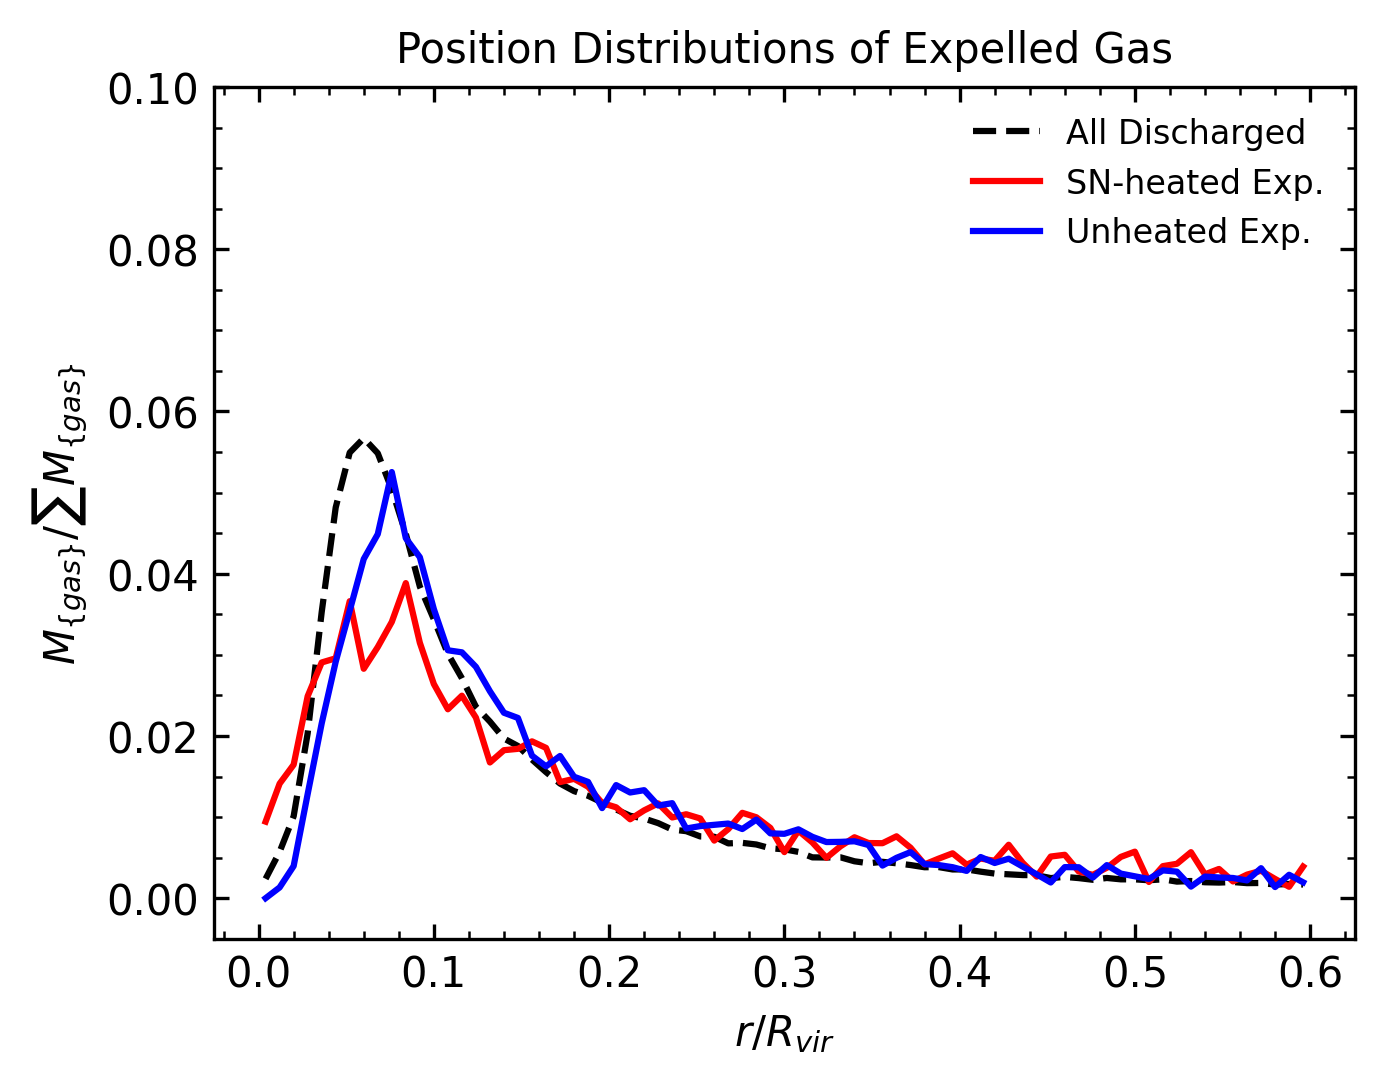

In [29]:
# compiling radial positions for each gas particle. data has precalculated key 
# 'r_per_Rvir', radial position normalized by the virial radius of the satellite, 
# that we will use for our position computations here.


##### plotting unheated vs. heated discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y3, x = np.histogram(discharged.r_per_Rvir, bins=bins, weights=wt(discharged),
                     range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y3, label='All Discharged', linestyle='--', color='black')

y1, x = np.histogram(hot_exp.r_per_Rvir, bins=bins, weights=wt(hot_exp), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated Exp.', color='r')

y2, x = np.histogram(cold_exp.r_per_Rvir, bins=bins, weights=wt(cold_exp), range=(0, 0.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated Exp.', color='b')



# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Position Distributions of Expelled Gas', fontsize='medium')
ax.set_xlabel(r'$r/R_{vir}$')
plt.ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(0,1)
ax.set_ylim(-0.005,0.1)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))


ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/rPerRvir_exp.pdf')

plt.show()

### Radial Velocity Distributions (Expelled) <a class="anchor" id="velocityexpelled"></a>

___

#### Scaling by $V_{vir}$:


In [31]:
# gravitational constant in units of kpc km**2 Msol**-1 s**-2 (matching sim. units).
G = c.G.to('kpc km2 / (M_sun s2)')

In [32]:
# compiling virial velocities for each particle's respective satellite.
# all discharged gas.
post_vvir = np.sqrt(G * discharged.sat_Mvir / discharged.satRvir)

# SN-heated and unheated discharged gas.
hot_exp_vvir = np.sqrt(G * hot_exp.sat_Mvir / hot_exp.satRvir)
cold_exp_vvir = np.sqrt(G * cold_exp.sat_Mvir / cold_exp.satRvir)


# creating callable key for effective velocity.
discharged['v_per_Vvir'] = discharged.v / post_vvir
hot_exp['v_per_Vvir'] = hot_exp.v / hot_exp_vvir
cold_exp['v_per_Vvir'] = cold_exp.v / cold_exp_vvir

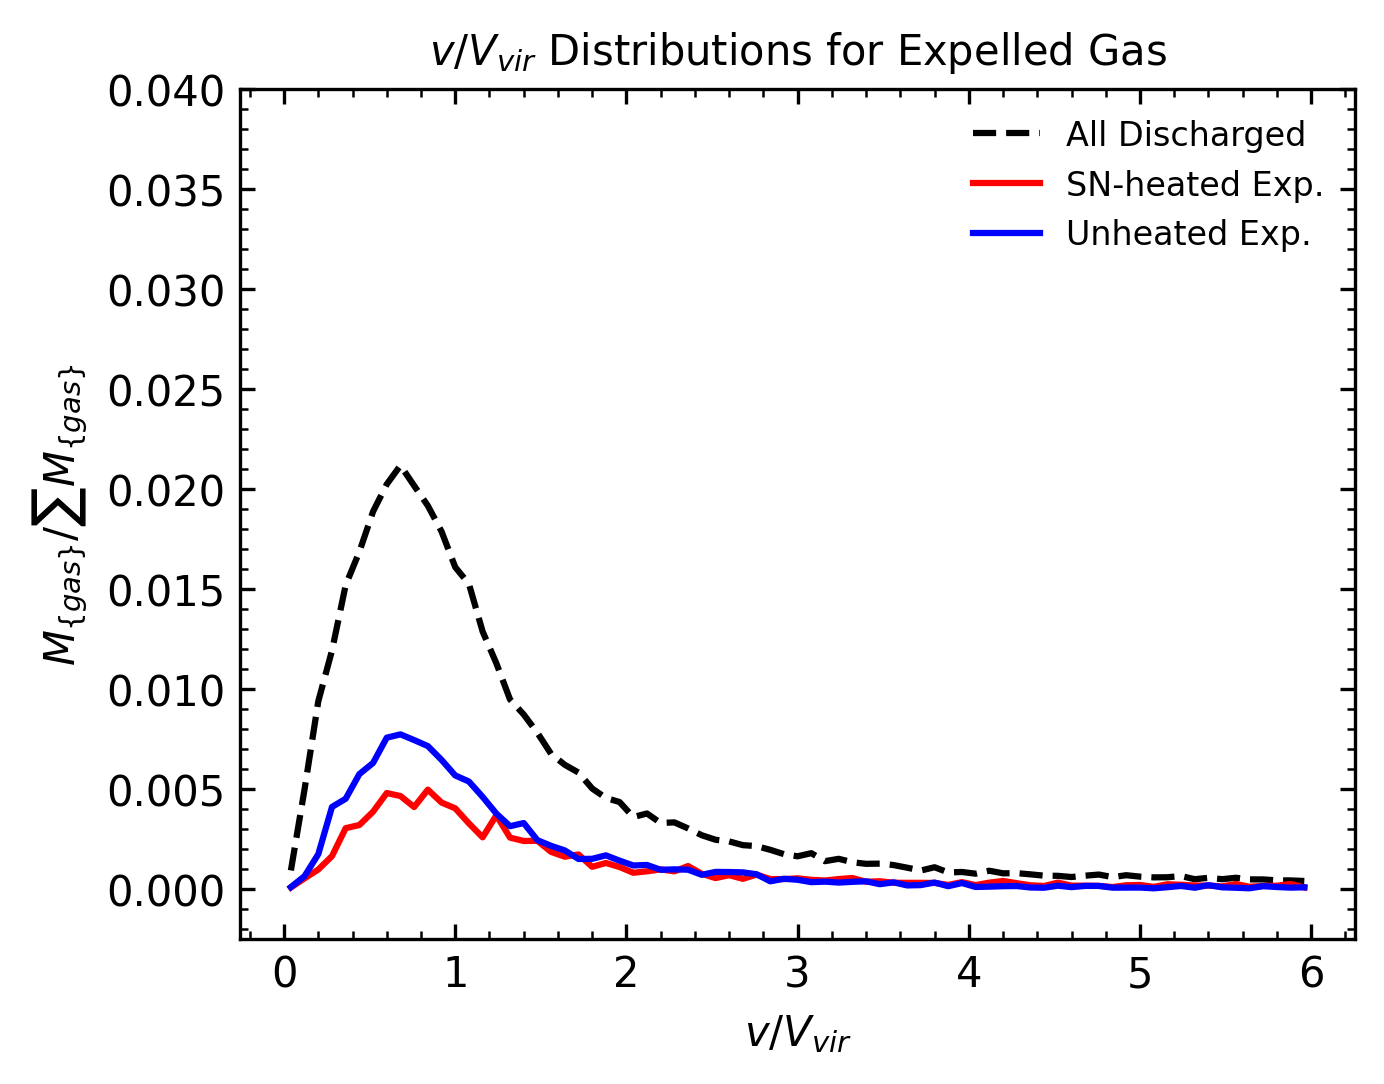

In [34]:
##### plotting all unheated vs. SN-heated, discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y3, x = np.histogram(discharged.v_per_Vvir, bins=bins, weights=wt(discharged),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y3, label='All Discharged', linestyle='--', color='black')

y1, x = np.histogram(hot_exp.v_per_Vvir, bins=bins, weights=wt(hot_exp,discharged),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated Exp.', color='r')

y2, x = np.histogram(cold_exp.v_per_Vvir, bins=bins, weights=wt(cold_exp,discharged),
                     range=(0, 6.0))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated Exp.', color='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('$v/V_{vir}$ Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
ax.set_ylim(-0.0025,0.04)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVvir_exp.pdf')

plt.show()


___

#### Scaling by $V_{esc}$:

In [73]:
# function to compute the radial distance between a gas particle's satellite
# and the satellite's host.
@pynbody.derived_array
def rSat(gas):
    return np.sqrt((gas.sat_Xc-gas.host_Xc)**2
                   + (gas.sat_Yc-gas.host_Yc)**2 
                   + (gas.sat_Zc-gas.host_Zc)**2)

In [74]:
# compiling escaped velocities for each particle's respective satellite.
# all discharged gas.
post_vesc = np.sqrt(2 * G * discharged.sat_Mvir / rSat(discharged))

# SN-heated and unheated discharged gas.
hot_exp_vesc = np.sqrt(2 * G * hot_exp.sat_Mvir / rSat(hot_exp))
cold_exp_vesc = np.sqrt(2 * G * cold_exp.sat_Mvir / rSat(cold_exp))


# creating callable key for effective velocity.
discharged['v_per_Vesc'] = discharged.v / post_vesc
hot_exp['v_per_Vesc'] = hot_exp.v / hot_exp_vesc
cold_exp['v_per_Vesc'] = cold_exp.v / cold_exp_vesc

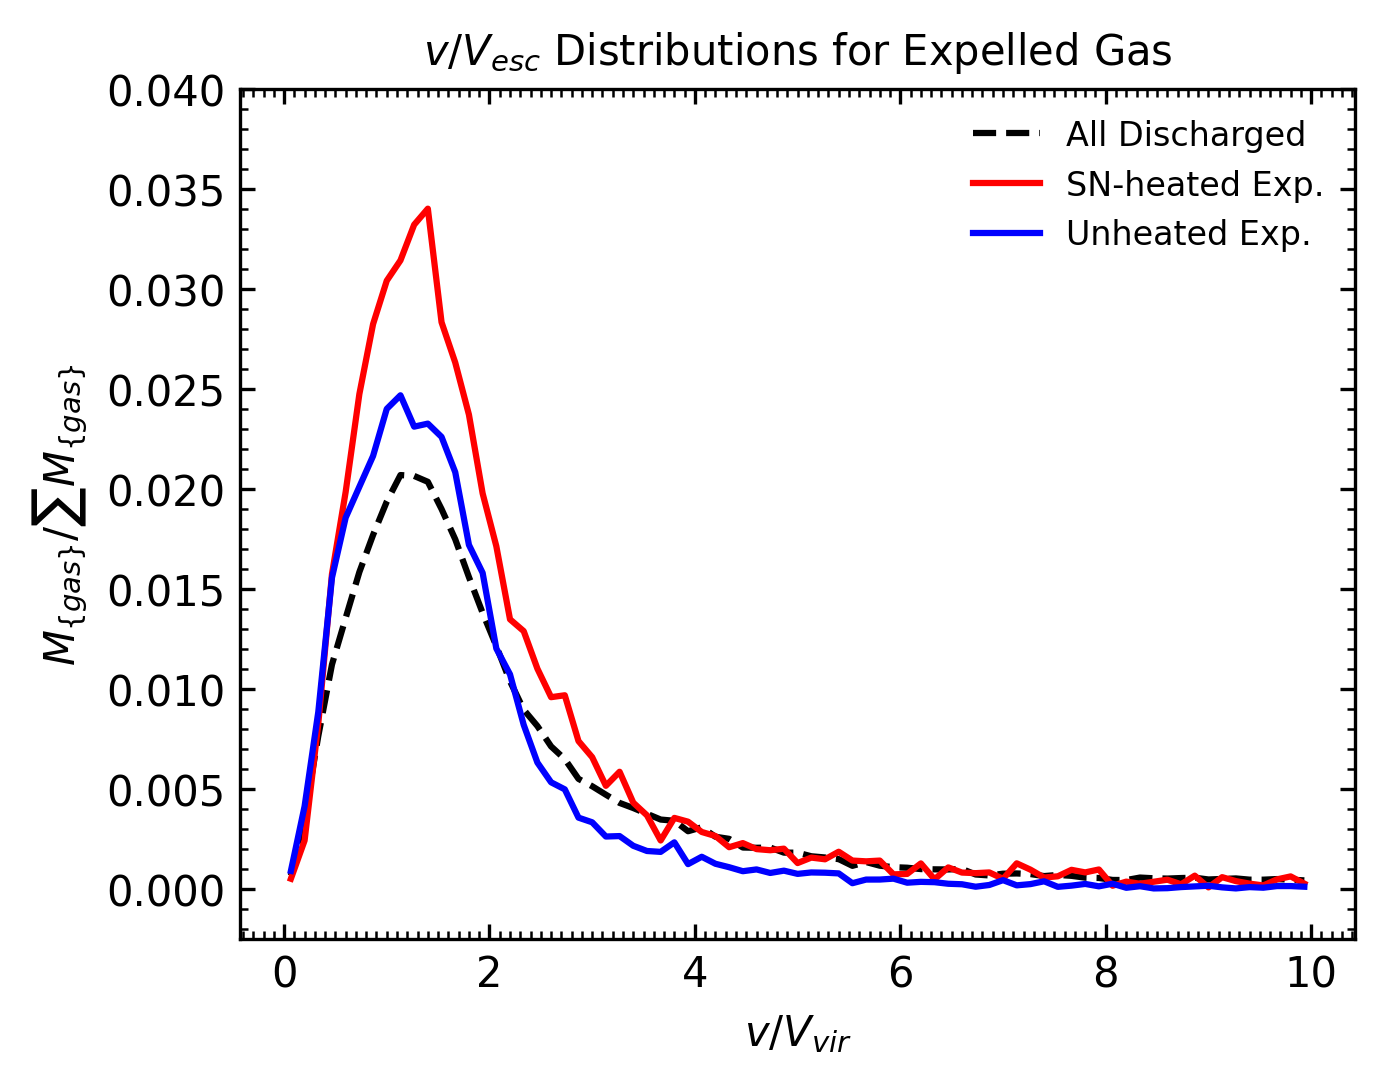

In [79]:
##### plotting all unheated vs. SN-heated, discharged gas #####
bins = 75
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y2, x = np.histogram(discharged.v_per_Vesc, bins=bins, weights=wt(discharged), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='All Discharged', linestyle='--', color='black')

y1, x = np.histogram(hot_exp.v_per_Vesc, bins=bins, weights=wt(hot_exp), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated Exp.', color='r')

y2, x = np.histogram(cold_exp.v_per_Vesc, bins=bins, weights=wt(cold_exp), range=(0, 10))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated Exp.', color='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('$v/V_{esc}$ Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'$v/V_{vir}$')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
# ax.set_xlim(-50,150)
ax.set_ylim(-0.0025,0.04)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.001))
 
ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/vPerVesc_exp.pdf')

plt.show()

###  Gas Temperatures (Expelled) <a class="anchor" id="temperaturesexpelled"></a>

___


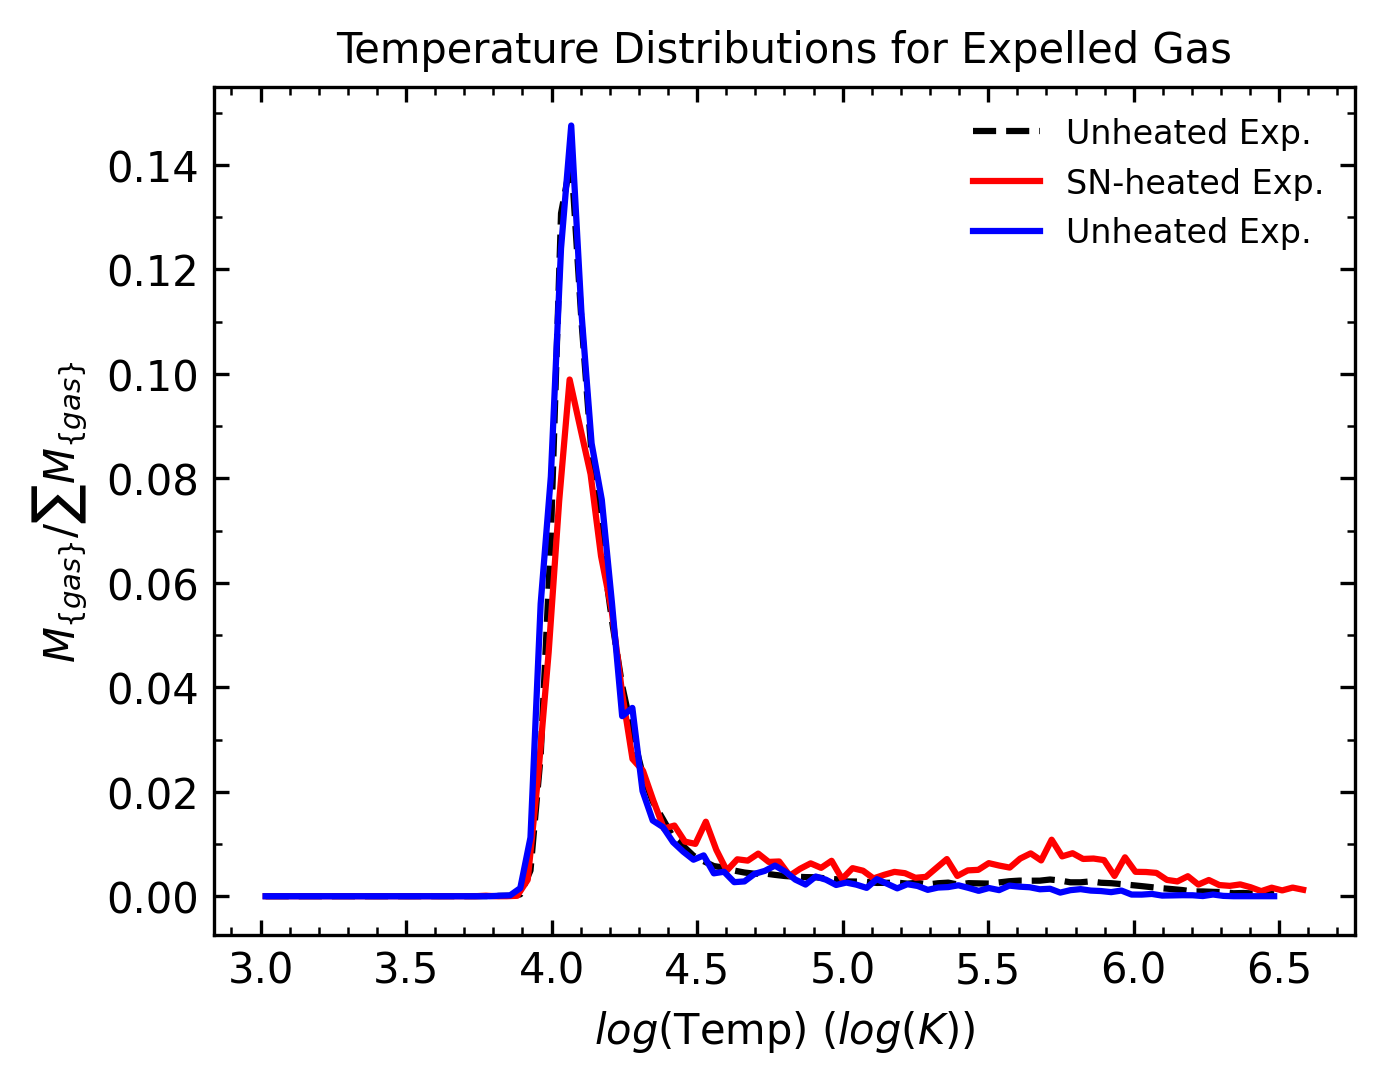

In [35]:
##### plotting discharged vs. heated gas #####
bins = 100
fig, ax = plt.subplots(1,1,dpi=300, figsize=(4.5,3.5), constrained_layout=True)

y2, x = np.histogram(np.log10(discharged.temp), bins=bins, weights=wt(discharged), range=(3.0,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated Exp.', linestyle='--', c='black')

y1, x = np.histogram(np.log10(hot_exp.temp), bins=bins, weights=wt(hot_exp), range=(3.0,6.6))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y1, label='SN-heated Exp.', c='r')

y2, x = np.histogram(np.log10(cold_exp.temp), bins=bins, weights=wt(cold_exp), range=(3.0,6.5))
bincenters = 0.5*(x[1:] + x[:-1])
ax.plot(bincenters, y2, label='Unheated Exp.', c='b')


# labels, axis scaling, etc.
ax.legend(frameon=False, fontsize='8')

ax.set_title('Temperature Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'$log$(Temp) ($log(K)$)')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')

# ax.set_xlim(3,8)
# ax.set_ylim(-0.01,0.30)

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.ticklabel_format(axis="y", style="plain",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/T_dist_exp.pdf')

plt.show()

###  Exit Angles of Expelled Gas <a class="anchor" id="anglesexpelled"></a>

___


In [36]:
# constructing bins for exit angle histograms.
N = 30
theta1,theta2 = 0,0 # initialize
bins = np.array([theta1]) 
while theta2 < 3.14:
    theta2 = np.arccos(np.cos(theta1)-(2/N))
    bins = np.append(bins,theta2)
    theta1 = theta2

bins = bins*180/np.pi
bincenters = 0.5*(bins[1:]+bins[:-1])

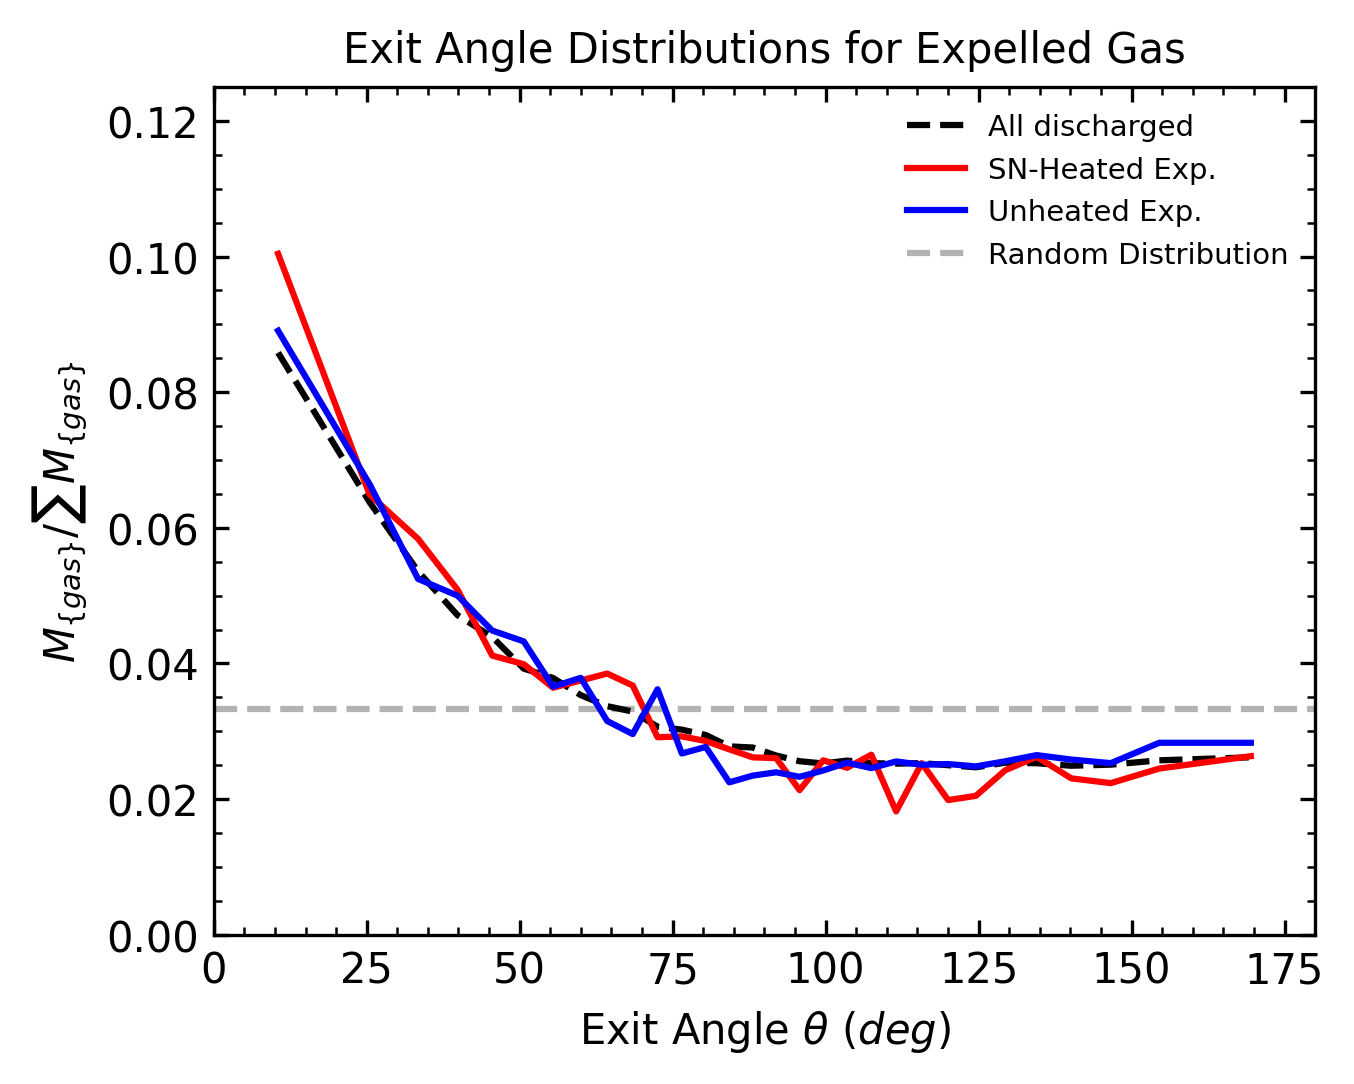

In [37]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True) 

# applying conditional on distances of gas from center of satellite; collecting 
# frequency and bin information for plot.
y1, bins = np.histogram(discharged.angle, bins=bins, weights=wt(discharged))
ax.plot(bincenters, y1, label='All discharged', linestyle='--', c='black')

y2, bins = np.histogram(hot_exp.angle, bins=bins, weights=wt(hot_exp))
ax.plot(bincenters, y2, label='SN-Heated Exp.', c='r')

y3, bins = np.histogram(cold_exp.angle, bins=bins, weights=wt(cold_exp))
ax.plot(bincenters, y3, label='Unheated Exp.', c='b')


# line representing random distribution.
percent = 1/N
ax.plot([0,180],[percent,percent],linestyle='--',color='0.7',zorder=-1,
        label='Random Distribution')


# labels, axis scaling, etc.
ax.set_title('Exit Angle Distributions for Expelled Gas', fontsize='medium')
ax.set_xlabel(r'Exit Angle $\theta$ ($deg$)')
ax.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax.set_xlim(0,180)
ax.set_ylim(0,0.125)

ax.legend(frameon=False, fontsize='7')

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.005))
#ax.ticklabel_format(axis="y", style="sci",scilimits=(0,0))
ax.tick_params(direction='in',which='both',right=True,top=True)

plt.savefig('F21plots/angles_dist_exp.pdf')
plt.show()

### Proportions of Expelled Gas SN-heated Across Radial Distances <a class="anchor" id="fractionexpelled"></a>

___


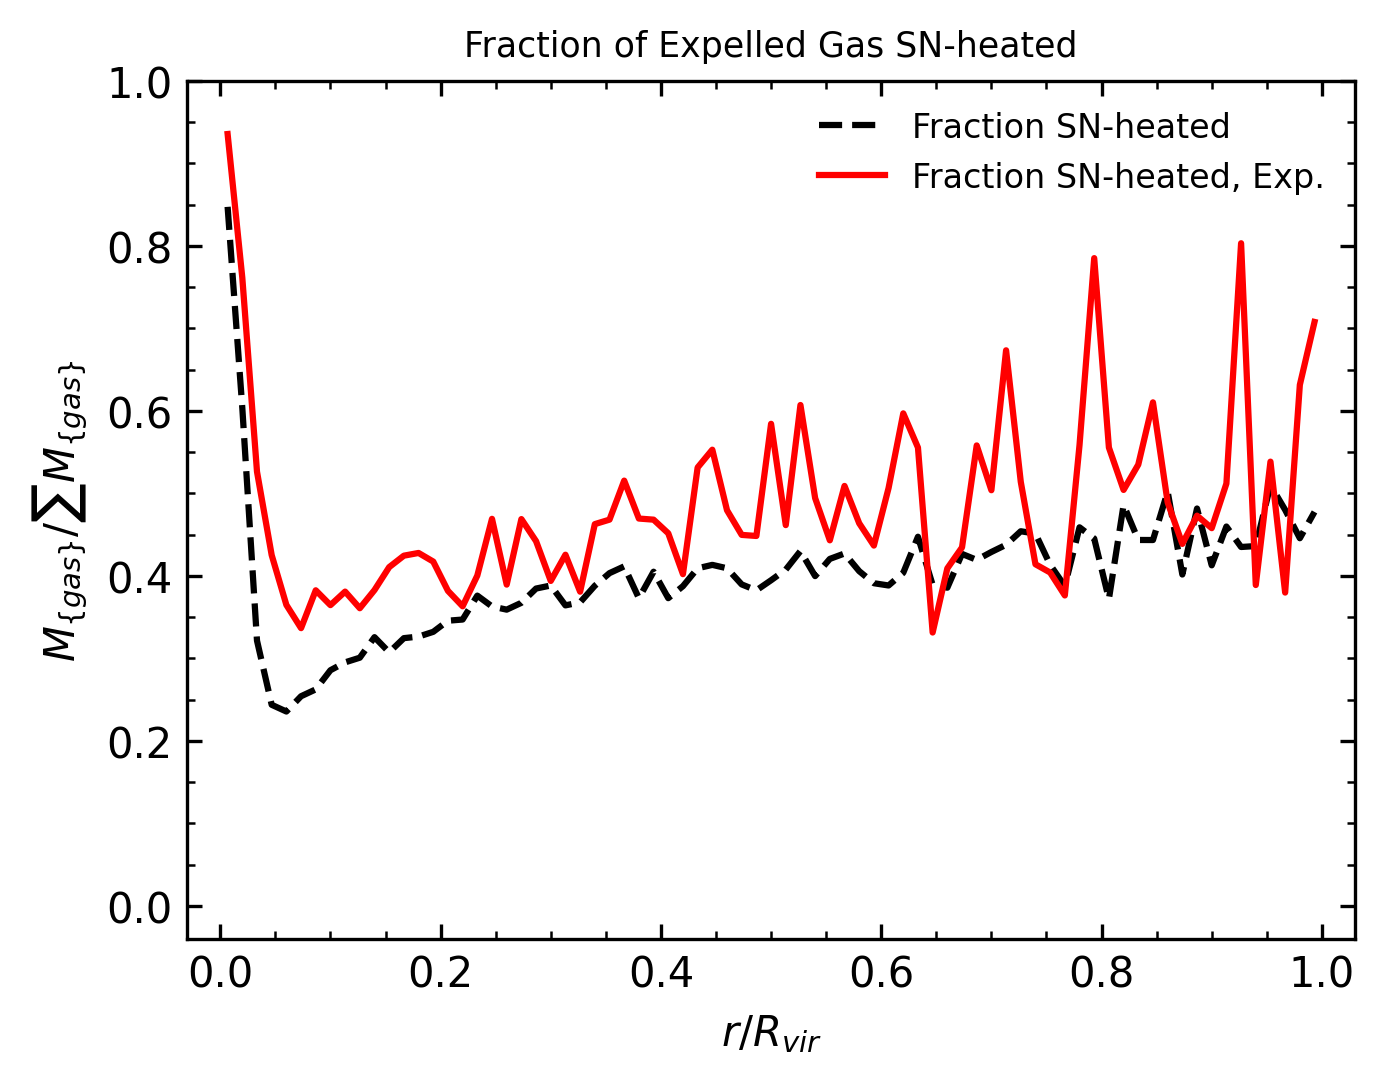

In [38]:
bins = 75
rangemax = 1.0

# assigning particles in each set to equal sets of bins.

# all discharged gas.
post, x = np.histogram(discharged.r_per_Rvir, bins=bins, range=(0,rangemax))
post_exp, x = np.histogram(expelled.r_per_Rvir, bins=bins, range=(0,rangemax))

# SN-heated, discharged.
postHot, x = np.histogram(hot.r_per_Rvir, bins=bins, range=(0,rangemax))
postHot_exp, x = np.histogram(hot_exp.r_per_Rvir, bins=bins, range=(0,rangemax))


# computing fraction hot/all for each bin.
sn_ratio = np.array([])
sn_ratio_exp = np.array([])

for i in range(0, bins):
    ratio = postHot[i]/post[i]
    sn_ratio = np.append(sn_ratio, ratio)
    i += 1
    
for i in range(0, bins):
    ratio = postHot_exp[i]/post_exp[i]
    sn_ratio_exp = np.append(sn_ratio_exp, ratio)
    i += 1


### plotting fractions heated/discharged for different r/Rvir bins ###
# ax1 = plot of heated/discharged ratios;
# ax2 = plot for percent mass of discharged and SN-heated, discharged gas, respectively, 
# at different r/Rvir.
fig, ax1 = plt.subplots(1, 1, dpi=300, figsize=(4.5,3.5), constrained_layout=True)

bincenters = 0.5*(x[1:] + x[:-1])
ax1.plot(bincenters, sn_ratio, label='Fraction SN-heated', linestyle='--', c='black', zorder=-1000)
ax1.plot(bincenters, sn_ratio_exp, label='Fraction SN-heated, Exp.', c='r')

ax1.set_title('Fraction of Expelled Gas SN-heated', fontsize='small')
ax1.set_xlabel(r'$r/R_{vir}$')
ax1.set_ylabel('% SN-heated Exp.')
ax1.set_ylabel('$M_{\{gas\}} / \sum M_{\{gas\}}$')
ax1.legend(frameon=False, fontsize='8')

ax1.set_xlim(-0.03,1.03)
ax1.set_ylim(-0.04,1)

ax1.tick_params(direction='in',which='both',right=True,top=True)
ax1.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))
ax1.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

ax1.ticklabel_format(axis="y", style="plain",scilimits=(0,0))

plt.savefig('F21plots/sn_fraction_exp.pdf')

plt.show()